In [3]:
import math
import random
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [6]:
%run 'functions.py'

In [4]:
total_usage_2012 = pd.read_parquet('../data/total_usage_2012.gzip')
# total_usage_2013 = pd.read_parquet('../data/total_usage_2013.gzip')
# total_usage_2014 = pd.read_parquet('../data/total_usage_2014.gzip')

Split tariffs into low, normal, high and find 
1. the number of days that have low, normal, high and 
2. the number of days that have low or high (a pricing event)

In [13]:
tariffs = pd.read_parquet('../data/tariffs.gzip')

lows = np.array(tariffs.index[tariffs['tariff'] == 'Low'], dtype=np.datetime64)
normals = np.array(tariffs.index[tariffs['tariff'] == 'Normal'], dtype=np.datetime64)
highs = np.array(tariffs.index[tariffs['tariff'] == 'High'], dtype=np.datetime64)

lows_2012 = lows - np.timedelta64(365, 'D')
normals_2012 = normals - np.timedelta64(365, 'D')
highs_2012 = highs - np.timedelta64(365, 'D')

In [14]:
# include a p/kWh & p/hh column that includes the price for that hh
total_usage_2012['p/kWh'] = 14.228
total_usage_2012['p/hh'] = total_usage_2012['KWH/hh'] * total_usage_2012['p/kWh']

total_usage_2013.loc[total_usage_2013['treated'], 'p/kWh'] = tariffs.loc[total_usage_2013.loc[total_usage_2013['treated'], 'date_time'], 'p/kWh'].values
total_usage_2013.loc[~total_usage_2013['treated'], 'p/kWh'] = 14.228
total_usage_2013['p/hh'] = total_usage_2013['KWH/hh'] * total_usage_2013['p/kWh']

Count the number of time indices in 2013 that had a high or low price

In [6]:
tariffs_ = tariffs.reset_index()
tariffs_['date_time'] = tariffs_['date_time'].dt.normalize()
tariffs_.loc[(tariffs_['tariff'] == 'Low') | (tariffs_['tariff'] == 'High')]['date_time'].nunique()

153

In [6]:
tariffs_.groupby('tariff')['date_time'].nunique()

tariff
High       77
Low       104
Normal    357
Name: date_time, dtype: int64

Count the number of unique values in acorn_group and acorn_category

In [23]:
total_acorn = pd.read_parquet('../data/total_acorn.gzip')

affluent = total_acorn.loc[total_acorn['acorn_category'] == 'Affluent']['house_id']
comfortable = total_acorn.loc[total_acorn['acorn_category'] == 'Comfortable']['house_id']
adversity = total_acorn.loc[total_acorn['acorn_category'] == 'Adversity']['house_id']

In [26]:
print('Affluent:')
print(total_acorn.loc[total_acorn['acorn_category'] == 'Affluent']['acorn_group'].value_counts())
print('Comfortable:')
print(total_acorn.loc[total_acorn['acorn_category'] == 'Comfortable']['acorn_group'].value_counts())
print('Adversity:')
print(total_acorn.loc[total_acorn['acorn_category'] == 'Adversity']['acorn_group'].value_counts())

Affluent:
ACORN-E    1567
ACORN-D     292
ACORN-A     157
ACORN-C     151
ACORN-B      25
Name: acorn_group, dtype: int64
Comfortable:
ACORN-F    684
ACORN-H    455
ACORN-G    205
ACORN-J    112
ACORN-I     51
Name: acorn_group, dtype: int64
Adversity:
ACORN-Q    831
ACORN-L    342
ACORN-K    165
ACORN-N    152
ACORN-M    113
ACORN-P    110
ACORN-O    103
Name: acorn_group, dtype: int64


In [8]:
# these datapoints don't have a correct acorn category or group
# ACORN-U & ACORN-
total_acorn['acorn_category'].value_counts()

Affluent       2192
Adversity      1816
Comfortable    1507
ACORN-U          49
ACORN-            2
Name: acorn_category, dtype: int64

In [5]:
# seperate minute, hour, day, month, and day of the week 
# from datetime object and add to the total_usage dataframe
total_usage_2012['month'] = total_usage_2012['date_time'].dt.month
# total_usage_2012['day'] = total_usage_2012['date_time'].dt.day
# total_usage_2012['hour'] = total_usage_2012['date_time'].dt.hour
# total_usage_2012['minute'] = total_usage_2012['date_time'].dt.minute
total_usage_2012['day_of_week'] = total_usage_2012['date_time'].dt.dayofweek

In [6]:
total_usage_2013['month'] = total_usage_2013['date_time'].dt.month
# total_usage_2013['day'] = total_usage_2013['date_time'].dt.day
# total_usage_2013['hour'] = total_usage_2013['date_time'].dt.hour
# total_usage_2013['minute'] = total_usage_2013['date_time'].dt.minute
total_usage_2013['day_of_week'] = total_usage_2013['date_time'].dt.dayofweek

In [145]:
no_missing = b1.isnull().sum(axis=1) == 0
keep_2012_t = set(no_missing.loc[no_missing].index)

no_missing = b2.isnull().sum(axis=1) == 0
keep_2013_t = set(no_missing.loc[no_missing].index)

In [146]:
print(len(b1), len(keep_2012_t))
print(len(b2), len(keep_2013_t))

1116 352
1093 443


In [147]:
slice_2012_t_dropped = slice_2012_t.loc[slice_2012_t['house_id'].isin(keep_2012_t)]
slice_2013_t_dropped = slice_2013_t.loc[slice_2013_t['house_id'].isin(keep_2013_t)]

In [137]:
# axis=1 is over the rows
# axis=0 is over the columns

a1_imputed_ = impute(a1.values, np.nanmedian, 0)
a2_imputed_ = impute(a2.values, np.nanmedian, 0)

a1_imputed = pd.DataFrame(a1_imputed_, columns=a1.columns, index=a1.index)
a2_imputed = pd.DataFrame(a2_imputed_, columns=a2.columns, index=a2.index)

In [148]:
b1_imputed_ = impute(b1.values, np.nanmedian, 0)
b2_imputed_ = impute(b2.values, np.nanmedian, 0)

b1_imputed = pd.DataFrame(b1_imputed_, columns=b1.columns, index=b1.index)
b2_imputed = pd.DataFrame(b2_imputed_, columns=b2.columns, index=b2.index)

In [160]:
a1_dropped = slice_2012_dropped.pivot_table(index='house_id', columns='date_time', values='KWH/hh')
a2_dropped = slice_2013_dropped.pivot_table(index='house_id', columns='date_time', values='KWH/hh')

In [149]:
b1_dropped = slice_2012_t_dropped.pivot_table(index='house_id', columns='date_time', values='KWH/hh')
b2_dropped = slice_2013_t_dropped.pivot_table(index='house_id', columns='date_time', values='KWH/hh')

In [142]:
print(a1_dropped.shape)
print(a2_dropped.shape)

(1332, 8832)
(1665, 8832)


In [150]:
print(b1_dropped.shape)
print(b2_dropped.shape)

(352, 8832)
(443, 8832)


In [32]:
# time_of_day_2012 = slice_2012.groupby([slice_2012['date_time'].dt.time, slice_2012['day_of_week']])['KWH/hh'].mean()
# time_of_day_2013 = slice_2013.groupby([slice_2013['date_time'].dt.time, slice_2013['day_of_week']])['KWH/hh'].mean()

time_of_day_2012_af = slice_2012_af.groupby([slice_2012_af['date_time'].dt.time, slice_2012_af['day_of_week']])['KWH/hh'].mean()
time_of_day_2012_com = slice_2012_com.groupby([slice_2012_com['date_time'].dt.time, slice_2012_com['day_of_week']])['KWH/hh'].mean()
time_of_day_2012_ad = slice_2012_ad.groupby([slice_2012_ad['date_time'].dt.time, slice_2012_ad['day_of_week']])['KWH/hh'].mean()

day_of_week_time_of_day_2012_af = time_of_day_2012_af.unstack()
day_of_week_time_of_day_2012_com = time_of_day_2012_com.unstack()
day_of_week_time_of_day_2012_ad = time_of_day_2012_ad.unstack()

In [33]:
time_of_day_2013_af = slice_2013_af.groupby([slice_2013_af['date_time'].dt.time, slice_2013_af['day_of_week']])['KWH/hh'].mean()
time_of_day_2013_com = slice_2013_com.groupby([slice_2013_com['date_time'].dt.time, slice_2013_com['day_of_week']])['KWH/hh'].mean()
time_of_day_2013_ad = slice_2013_ad.groupby([slice_2013_ad['date_time'].dt.time, slice_2013_ad['day_of_week']])['KWH/hh'].mean()

day_of_week_time_of_day_2013_af = time_of_day_2013_af.unstack()
day_of_week_time_of_day_2013_com = time_of_day_2013_com.unstack()
day_of_week_time_of_day_2013_ad = time_of_day_2013_ad.unstack()

- c1 sin(x) + c2 + c3
- temp, day of week, season, socio
- decision tree regressor: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [35]:
pd.plotting.register_matplotlib_converters()

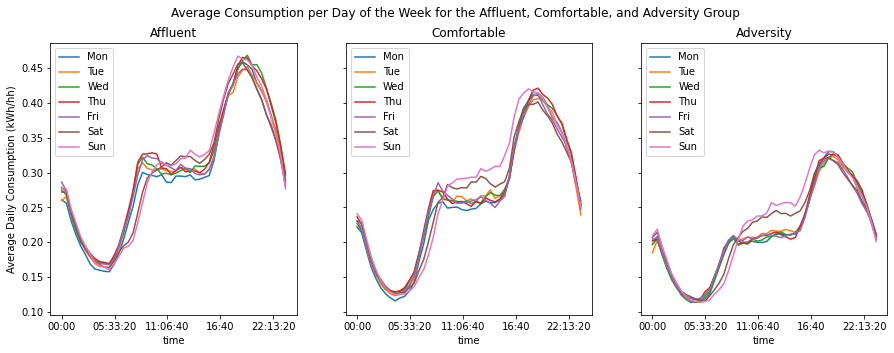

In [59]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))
fig.suptitle('Average Consumption per Day of the Week for the Affluent, Comfortable, and Adversity Group')
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for i in range(7):
    ax[0].plot(day_of_week_time_of_day_2012_af[i], label=labels[i])
ax[0].set_title('Affluent')
ax[0].set_ylabel('Average Daily Consumption (kWh/hh)')
ax[0].legend(loc=2)

for i in range(7):
    ax[1].plot(day_of_week_time_of_day_2012_com[i], label=labels[i])
ax[1].set_title('Comfortable')
ax[1].legend(loc=2)

for i in range(7):
    ax[2].plot(day_of_week_time_of_day_2012_ad[i], label=labels[i])
ax[2].set_title('Adversity')
ax[2].legend(loc=2)

plt.savefig('../figs/day_of_week_socio.png');

In [1]:
mean_per_hh_2012_af = slice_2012_af.groupby('date_time')['KWH/hh'].mean()
mean_per_hh_2012_com = slice_2012_com.groupby('date_time')['KWH/hh'].mean()
mean_per_hh_2012_ad = slice_2012_ad.groupby('date_time')['KWH/hh'].mean()

NameError: name 'slice_2012_af' is not defined

In [54]:
mean_per_hh_2013_af = slice_2013_af.groupby('date_time')['KWH/hh'].mean()
mean_per_hh_2013_com = slice_2013_com.groupby('date_time')['KWH/hh'].mean()
mean_per_hh_2013_ad = slice_2013_ad.groupby('date_time')['KWH/hh'].mean()

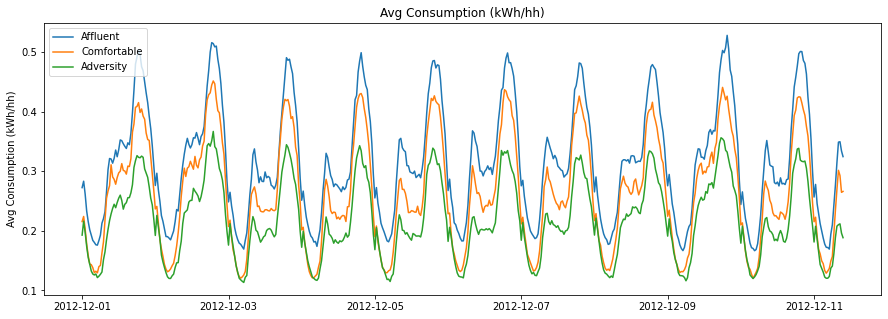

In [58]:
plt.figure(figsize=(15, 5))
n=500
plt.plot(mean_per_hh_2012_af[:n], label='Affluent')
plt.plot(mean_per_hh_2012_com[:n], label='Comfortable')
plt.plot(mean_per_hh_2012_ad[:n], label='Adversity')
plt.ylabel('Avg Consumption (kWh/hh)')
plt.title('Avg Consumption (kWh/hh)')
plt.legend()
plt.show()

In [196]:
day_of_week_2012 = slice_2012.groupby([slice_2012['day_of_week']])['KWH/hh'].mean()
day_of_week_2013 = slice_2013.groupby([slice_2013['day_of_week']])['KWH/hh'].mean()

In [199]:
slice_2012.groupby([slice_2012['date_time'].dt.normalize()])['KWH/hh'].mean()

,house_id,treated,date_time,KWH/hh,month,day,hour,minute,day_of_week
17501,MAC000003,False,2012-12-01 00:00:00,0.140,12,1,0,0,5
17502,MAC000003,False,2012-12-01 00:30:00,3.119,12,1,0,30,5
17503,MAC000003,False,2012-12-01 01:00:00,3.281,12,1,1,0,5
17504,MAC000003,False,2012-12-01 01:30:00,3.158,12,1,1,30,5
17505,MAC000003,False,2012-12-01 02:00:00,2.254,12,1,2,0,5
...,...,...,...,...,...,...,...,...,...
48458971,MAC005566,False,2012-12-31 21:30:00,0.133,12,31,21,30,0
48458972,MAC005566,False,2012-12-31 22:00:00,0.078,12,31,22,0,0
48458973,MAC005566,False,2012-12-31 22:30:00,0.107,12,31,22,30,0
48458974,MAC005566,False,2012-12-31 23:00:00,0.127,12,31,23,0,0


In [89]:
arr = a1.values
axis = 0
f = np.nanmedian
out = arr.copy()
np.copyto(out, f(arr, axis=axis, keepdims=True), where=np.isnan(arr))

In [90]:
out

array([[0.215    , 0.217    , 0.237    , ..., 0.22     , 0.236    ,
        0.229    ],
       [0.14     , 3.119    , 3.2809999, ..., 0.123    , 0.111    ,
        0.126    ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.175    ,
        0.       ],
       ...,
       [0.042    , 0.043    , 0.052    , ..., 0.328    , 0.344    ,
        0.339    ],
       [0.073    , 0.101    , 0.092    , ..., 0.107    , 0.127    ,
        0.109    ],
       [0.129    , 0.108    , 0.098    , ..., 0.046    , 0.068    ,
        0.057    ]])

In [91]:
arr

array([[0.215    , 0.217    , 0.237    , ..., 0.22     , 0.236    ,
        0.229    ],
       [0.14     , 3.119    , 3.2809999, ..., 0.123    , 0.111    ,
        0.126    ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.175    ,
        0.       ],
       ...,
       [0.042    , 0.043    , 0.052    , ..., 0.328    , 0.344    ,
        0.339    ],
       [0.073    , 0.101    , 0.092    , ..., 0.107    , 0.127    ,
        0.109    ],
       [      nan,       nan,       nan, ..., 0.046    , 0.068    ,
        0.057    ]])

In [95]:
a1.median(axis=0)

date_time
2012-12-01 00:00:00    0.129
2012-12-01 00:30:00    0.108
2012-12-01 01:00:00    0.098
2012-12-01 01:30:00    0.088
2012-12-01 02:00:00    0.081
                       ...  
2012-12-31 21:30:00    0.197
2012-12-31 22:00:00    0.191
2012-12-31 22:30:00    0.178
2012-12-31 23:00:00    0.170
2012-12-31 23:30:00    0.157
Length: 1488, dtype: float64

In [28]:
# splitting 2012 and 2013 data into treatment and control groups
# df_2011_treatment, df_2011_control = split_t_c(total_usage_2011)
df_2012_treatment, df_2012_control = split_t_c(total_usage_2012)
df_2013_treatment, df_2013_control = split_t_c(total_usage_2013)
# df_2014_treatment, df_2014_control = split_t_c(total_usage_2014)

1. get a slice of the data whose houses have that for the entirety of that slice

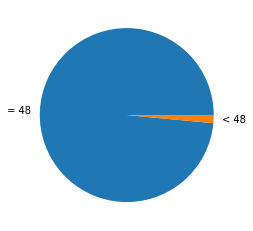

In [61]:
_48ers = count_hh_per_house_per_day_2012.loc[count_hh_per_house_per_day_2012.values == 48]
lessthan48ers = count_hh_per_house_per_day_2012.loc[count_hh_per_house_per_day_2012.values < 48]
plt.pie([len(x) for x in [_48ers, lessthan48ers]], labels=['= 48', '< 48']);

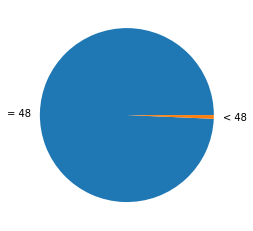

In [62]:
_48ers = count_hh_per_house_per_day_2013.loc[count_hh_per_house_per_day_2013.values == 48]
lessthan48ers = count_hh_per_house_per_day_2013.loc[count_hh_per_house_per_day_2013.values < 48]
plt.pie([len(x) for x in [_48ers, lessthan48ers]], labels=['= 48', '< 48']);

In [43]:
_42['KWH/hh'][1:].mean()

0.47345833750000005

In [44]:
_42['KWH/hh'].mean()

0.4675714326530612

In [182]:
# sums over the day and takes the mean over all houses
day_sum_2012_treatment = household_mean_daily_consumption(df_2012_treatment)
day_sum_2012_control = household_mean_daily_consumption(df_2012_control)

day_sum_2013_treatment = household_mean_daily_consumption(df_2013_treatment)
day_sum_2013_control = household_mean_daily_consumption(df_2013_control)

NameError: name 'df_2012_treatment' is not defined

In [119]:
a1.unstack()

date_time            house_id 
2012-12-01 00:00:00  MAC000002    0.215
                     MAC000003    0.140
                     MAC000004    0.000
                     MAC000006    0.030
                     MAC000007    0.085
                                  ...  
2012-12-31 23:30:00  MAC005555    0.117
                     MAC005561    0.098
                     MAC005562    0.339
                     MAC005566    0.109
                     MAC005567    0.057
Length: 6578448, dtype: float64

In [44]:
B = np.linalg.pinv(control_2013_time_of_day, rcond=0.01)

In [47]:
print(control_2013_time_of_day.shape)
print(u.shape, s.shape, vh.shape)

(48, 4411)
(48, 48) (48,) (4411, 4411)


In [58]:
u, s, vh = np.linalg.svd(control_2013_time_of_day)

In [56]:
find_top_components(s, 0.95)

2

In [64]:
# cross-validation

# a = a.T
# a_2013 = a_2013.T

# a_test = a[:math.floor(len(a)*0.2)]
# a_train = a[math.floor(len(a)*0.8):]
# a_2013_test = a_2013[:math.floor(len(a_2013)*0.2)]
# a_2013_train = a_2013[math.floor(len(a_2013)*0.8):]
u, s, v = np.linalg.svd(control_2013_time_of_day)

n_component = find_top_components(s, 0.95)

up = u[:, :n_component]
sp = s[:n_component]
vp = v[:n_component, :]

inverted = (vp.T @ np.linalg.inv(np.diag(sp))) @ up.T

In [78]:
np.linalg.pinv(control_2013_time_of_day) - inverted

array([[-0.00096459, -0.00042517,  0.00078897, ...,  0.00185547,
        -0.00549056,  0.00615983],
       [-0.01049494,  0.01607152,  0.09978461, ..., -0.00025904,
         0.02591685, -0.02125823],
       [ 0.00122317, -0.00263242,  0.00254398, ..., -0.00080883,
         0.00419091, -0.00117287],
       ...,
       [ 0.00104436, -0.00118426,  0.00081163, ...,  0.00109463,
        -0.00302748,  0.00040732],
       [ 0.00087011, -0.00247386,  0.00331278, ..., -0.00137135,
         0.00366275,  0.00060154],
       [ 0.00016919, -0.00013444,  0.00186666, ...,  0.00015689,
         0.00087239,  0.00137444]])

In [72]:
control_2013_time_of_day.shape

(48, 4411)

In [74]:
# control_2013_time_of_day @ np.linalg.pinv(control_2013_time_of_day)

In [180]:
# control_2013_time_of_day @ inverted

In [14]:
control_2013_time_of_day = df_2013_control.groupby(
    [df_2013_control['date_time'].dt.time, 
     df_2013_control['house_id']])['KWH/hh'].mean().unstack(level=1)

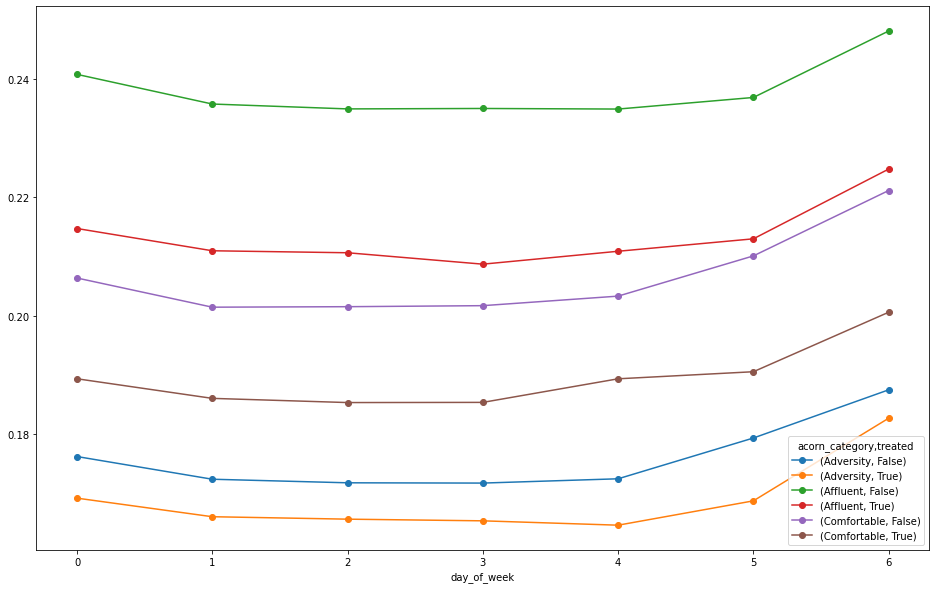

In [268]:
day_of_week_2012 = acorn_2012.groupby([acorn_2012['day_of_week'], acorn_2012['acorn_category']
                           , acorn_2012['treated']])['KWH/hh'].mean()
day_of_week_2012 = day_of_week_2012.unstack(level=1).unstack()
day_of_week_2012.plot(marker='o', figsize=(16,10));

In [199]:
day_of_week_2012 = total_usage_2012.groupby([total_usage_2012['day_of_week'], total_usage_2012['treated']])['KWH/hh'].mean()
day_of_week_2012 = day_of_week_2012.unstack()

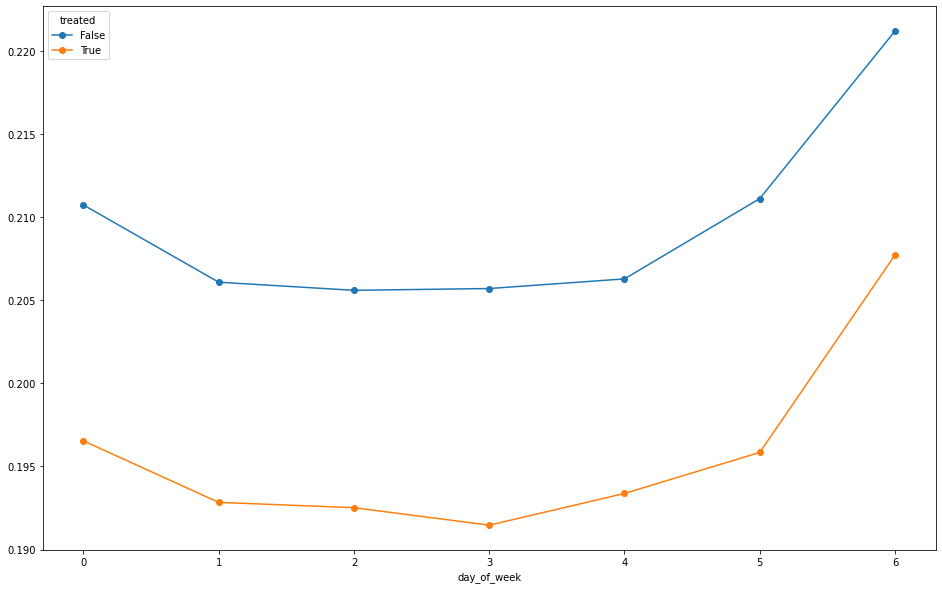

In [200]:
# monday is zero, sunday is 6
day_of_week_2012.plot(marker='o', figsize=(16,10));

In [403]:
month_of_year_2012 = acorn_2012.groupby([acorn_2012['month'], acorn_2012['acorn_category']
                           , acorn_2012['treated']])['KWH/hh'].mean()
month_of_year_2012 = month_of_year_2012.unstack(level=1).unstack()

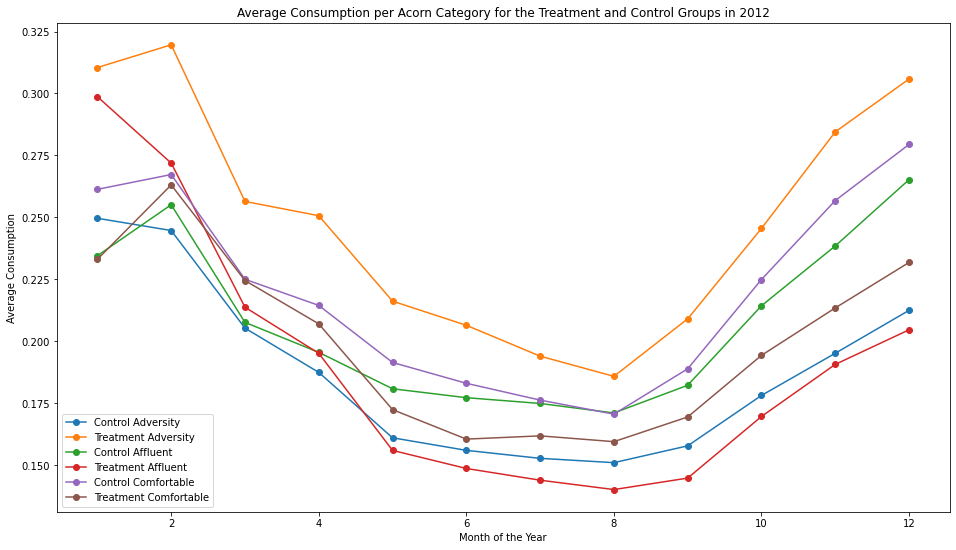

In [430]:
plt.figure(figsize=(16, 9))
plt.title('Average Consumption per Acorn Category for the Treatment and Control Groups in 2012')
plt.xlabel('Month of the Year')
plt.ylabel('Average Consumption')
plt.plot(month_of_year_2012, marker='o')
plt.savefig('month_of_year.png')
plt.legend(['Control Adversity', 'Treatment Adversity',
            'Control Affluent', 'Treatment Affluent',
            'Control Comfortable', 'Treatment Comfortable'])
plt.savefig('month_of_year.png')
plt.show()

In [245]:
temp = pd.read_csv('weather.csv', usecols=['DT', 'T2M'])
temp['DT'] = pd.to_datetime(temp['DT'])
temp.set_index('DT', inplace=True)

# remove feb 29, 2012 and anything 
temp = temp.loc[(temp.index != '2012-02-29')]

temp.head()

,T2M
DT,
2012-01-01,10.33
2012-01-02,5.68
2012-01-03,8.21
2012-01-04,6.21
2012-01-05,8.21


In [248]:
T_2012 = temp.loc[temp.index < '2013-01-01']['T2M']
T_2013 = temp.loc[(temp.index >= '2013-01-01') & (temp.index < '2014-01-01')]['T2M']
# T_2014 = temp.loc[()]

In [249]:
def func(x, a, b, c):
    return a/(x+b) + c

xdata = np.append(T_2012.values, [T_2012.values, T_2013.values, T_2013.values])
ydata = np.append(day_sum_2012_control[False].values, [day_sum_2012_treatment[True].values, 
                                                       day_sum_2013_control[False].values, day_sum_2013_treatment[True].values])

NameError: name 'day_sum_2012_control' is not defined

In [379]:
popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [600, 400, 15]))
popt

array([3.54176380e+02, 2.63707110e+01, 3.44880129e-16])

NameError: name 'xdata' is not defined

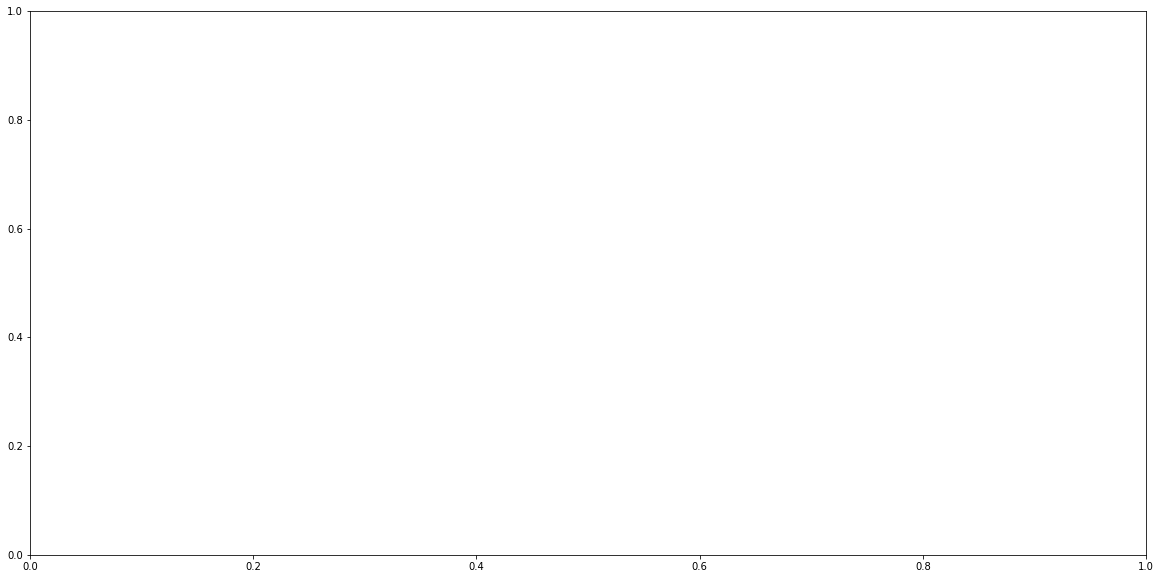

In [246]:
plt.subplots(figsize=(20, 10))
plt.scatter(xdata, ydata, label='actual data')
plt.plot(xdata, func(xdata, *popt), 'r', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.title('Consumption vs Temperature Fit')
plt.xlabel('Temperature')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.show()

In [171]:
day_sum_2012_treatment[True].corr(T_2012)

-0.8940282504986482

In [173]:
day_sum_2012_control[False].corr(T_2012)

-0.902788090740774

In [174]:
day_sum_2013_treatment[True].corr(T_2013)

-0.8941837334152689

In [175]:
day_sum_2013_control[False].corr(T_2013)

-0.9108167575243871

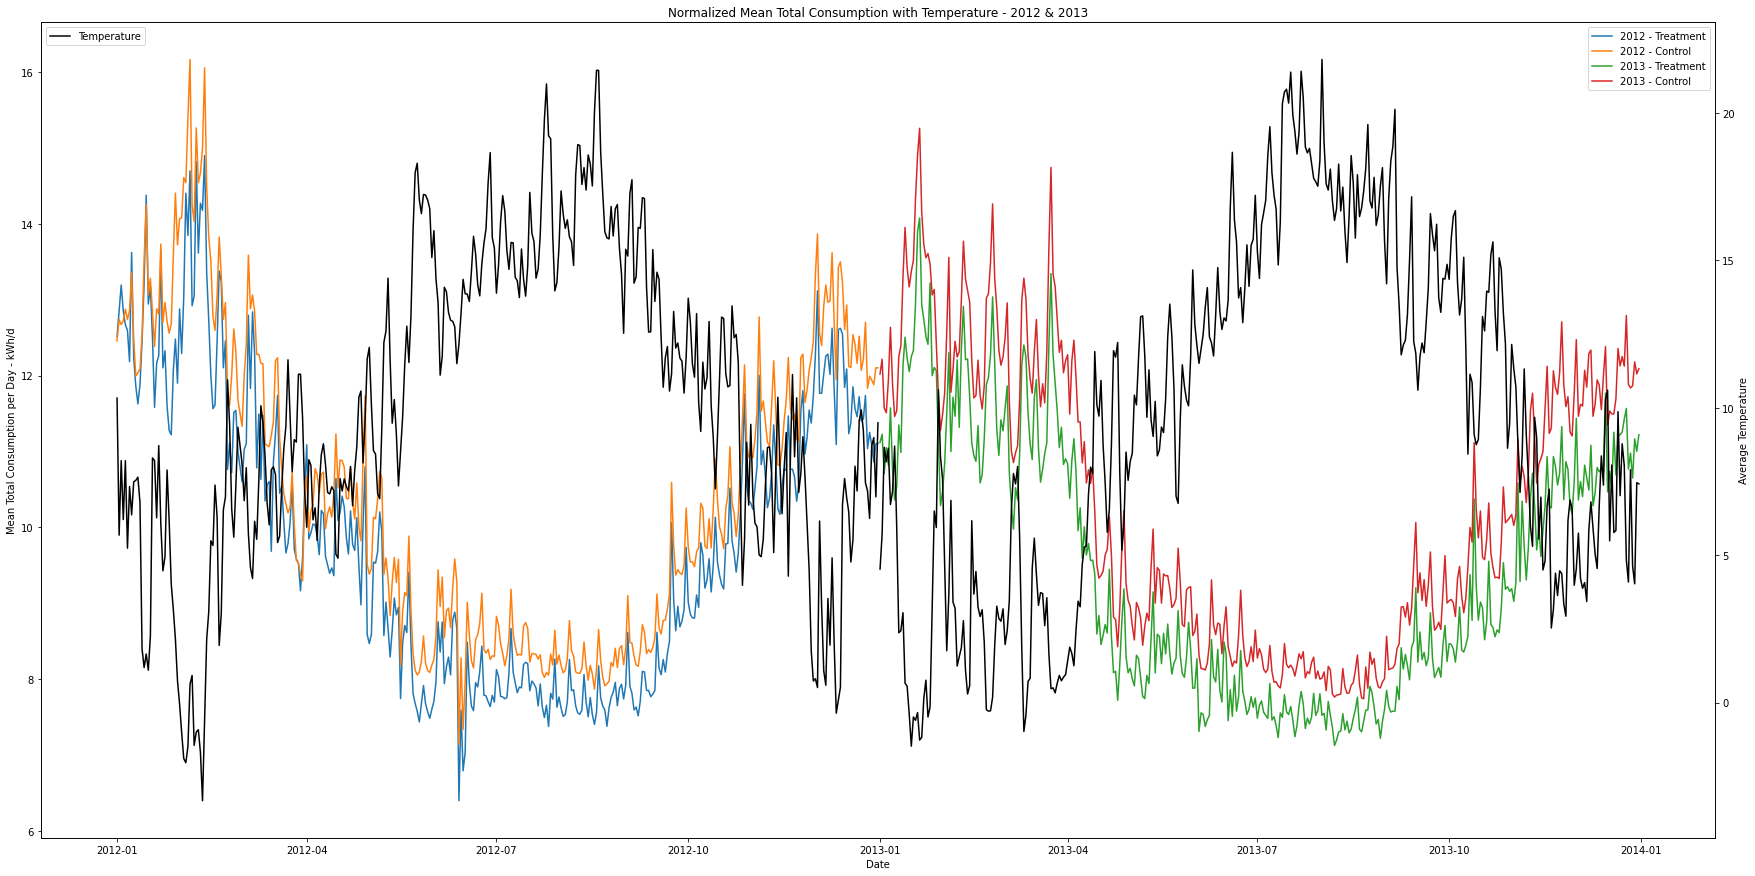

In [418]:
labels = ['2012 - Treatment', '2012 - Control', '2013 - Treatment', '2013 - Control']
title = 'Normalized Mean Total Consumption with Temperature - 2012 & 2013'

fig, ax = plt.subplots(figsize=(30, 15))
ax.plot(day_sum_2012_treatment[True].index, day_sum_2012_treatment[True].values, label=labels[0])
ax.plot(day_sum_2012_control[False].index, day_sum_2012_control[False].values, label=labels[1])
ax.plot(day_sum_2013_treatment[True].index, day_sum_2013_treatment[True].values, label=labels[2])
ax.plot(day_sum_2013_control[False].index, day_sum_2013_control[False].values, label=labels[3])

ax.legend(loc='upper right'); # upper left corner
ax.set_xlabel('Date')
ax.set_ylabel('Mean Total Consumption per Day - kWh/d')
ax.set_title(title)

ax2 = ax.twinx()
ax2.plot(T_2012.index, T_2012.values, color='black', label='Temperature')
ax2.plot(T_2013.index, T_2013.values, color='black')
ax2.legend(loc='upper left')
ax2.set_ylabel('Average Temperature')

plt.show()

In [203]:
acorn_2013 = pd.merge(total_usage_2013, total_acorn, how='left', on='house_id')
acorn_2012 = pd.merge(total_usage_2012, total_acorn, how='left', on='house_id')

In [242]:
acorn_2012 = acorn_2012.loc[(acorn_2012['acorn_category'] != 'ACORN-') & (acorn_2012['acorn_category'] != 'ACORN-U')]
acorn_2013 = acorn_2013.loc[(acorn_2013['acorn_category'] != 'ACORN-') & (acorn_2013['acorn_category'] != 'ACORN-U')]

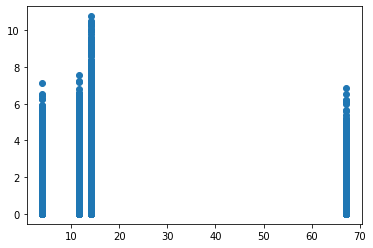

In [385]:
plt.scatter(acorn_2013['p/kWh'], acorn_2013['KWH/hh'])

In [422]:
test = acorn_2012.groupby([acorn_2012['date_time'].dt.time, acorn_2012['acorn_category']
                           , acorn_2012['treated']])['KWH/hh'].mean()

In [423]:
test.head()

date_time  acorn_category  treated
00:00:00   Adversity       False      0.136564
                           True       0.127977
           Affluent        False      0.186407
                           True       0.160735
           Comfortable     False      0.156960
Name: KWH/hh, dtype: float64

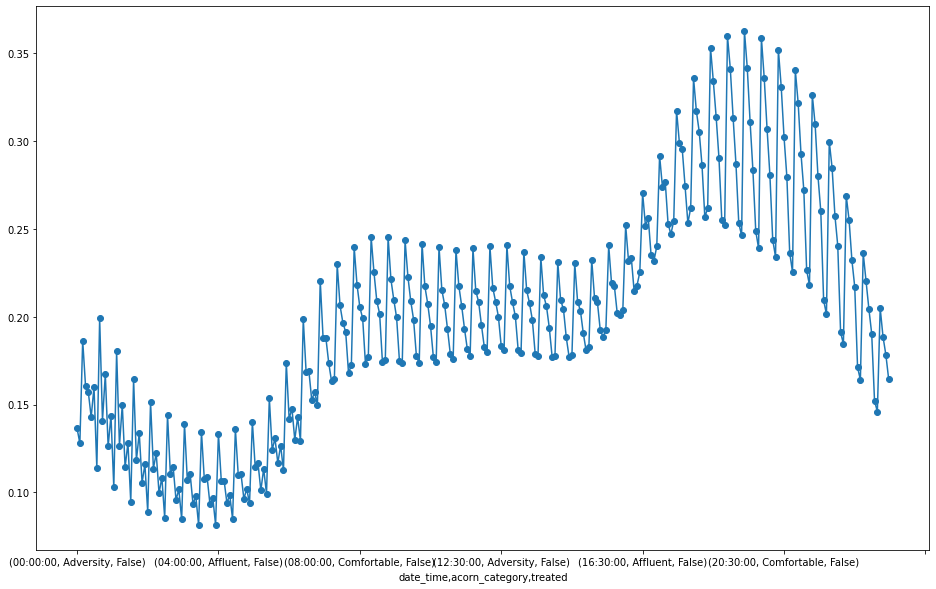

In [420]:
test.plot(marker='o', figsize=(16,10));

In [206]:
affluent_2013 = get_consumption_demographic(acorn_2013, 'Affluent')
comfortable_2013 = get_consumption_demographic(acorn_2013, 'Comfortable')
adversity_2013 = get_consumption_demographic(acorn_2013, 'Adversity')

affluent_2012 = get_consumption_demographic(acorn_2012, 'Affluent')
comfortable_2012 = get_consumption_demographic(acorn_2012, 'Comfortable')
adversity_2012 = get_consumption_demographic(acorn_2012, 'Adversity')

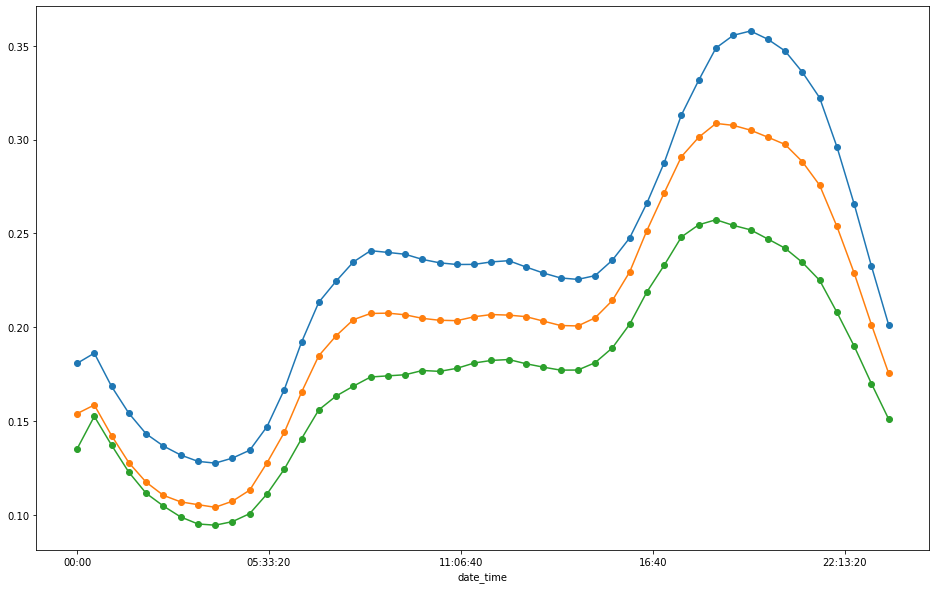

In [209]:
# time_of_day_affluent_2012 = affluent_2012.groupby([affluent_2012['date_time'].dt.time])['KWH/hh'].mean()
# time_of_day_comfortable_2012 = comfortable_2012.groupby([comfortable_2012['date_time'].dt.time])['KWH/hh'].mean()
# time_of_day_adversity_2012 = adversity_2012.groupby([adversity_2012['date_time'].dt.time])['KWH/hh'].mean()

time_of_day_affluent_2012.plot(marker='o', figsize=(16,10), label='affluent')
time_of_day_comfortable_2012.plot(marker='o', figsize=(16,10), label='comfortable')
time_of_day_adversity_2012.plot(marker='o', figsize=(16,10), label='adversity');

In [ ]:
affluent_2013_day_sum = household_mean_daily_consumption(affluent_2013)
comfortable_2013_day_sum = household_mean_daily_consumption(comfortable_2013)
adversity_2013_day_sum = household_mean_daily_consumption(adversity_2013)

affluent_2012_day_sum = household_mean_daily_consumption(affluent_2012)
comfortable_2012_day_sum = household_mean_daily_consumption(comfortable_2012)
adversity_2012_day_sum = household_mean_daily_consumption(adversity_2012)

comparing number of unique households in 2011-2014

In [426]:
# number of unique house_ids per day
unique_households_2011 = unique_house_per_hh(total_usage_2011)
unique_households_2012 = unique_house_per_hh(total_usage_2012)
unique_households_2013 = unique_house_per_hh(total_usage_2013)
unique_households_2014 = unique_house_per_hh(total_usage_2014)

unique_households_2011_treatment = unique_house_per_hh(df_2011_treatment)
unique_households_2012_treatment = unique_house_per_hh(df_2012_treatment)
unique_households_2013_treatment = unique_house_per_hh(df_2013_treatment)
unique_households_2014_treatment = unique_house_per_hh(df_2014_treatment)

unique_households_2011_control = unique_house_per_hh(df_2011_control)
unique_households_2012_control = unique_house_per_hh(df_2012_control)
unique_households_2013_control = unique_house_per_hh(df_2013_control)
unique_households_2014_control = unique_house_per_hh(df_2014_control)

NameError: name 'df_2011_treatment' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(unique_households_2011_control, color='royalblue', label='Control Group')
ax.plot(unique_households_2012_control, color='royalblue')
ax.plot(unique_households_2013_control, color='royalblue')
ax.plot(unique_households_2014_control, color='royalblue')

ax.plot(unique_households_2011_treatment, color='red', label='Treatment Group')
ax.plot(unique_households_2012_treatment, color='red')
ax.plot(unique_households_2013_treatment, color='red')
ax.plot(unique_households_2014_treatment, color='red')

ax.plot(unique_households_2011, color='green', label='All Houses')
ax.plot(unique_households_2012, color='green')
ax.plot(unique_households_2013, color='green') 
ax.plot(unique_households_2014, color='green')

ax.legend(loc=1)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Unique house_ids for Which There Is Data')
ax.set_title('Number of Unique Households during the Trial Period')
plt.savefig('unique_houses.png');

1. include all the data but impute the missing values (con: create data, pro: keeping everything-seasonality)
2. cut the data - trainig: later half of 2012 + 2014 (con: seasonality, the years are diffrnt circumstances)
3. drop some values, take the intersectin and keep that in your comparison

Now, let's see if the per house total consumption at the end of the year is lower in 2012 vs 2013

In [970]:
# col = 'KWH/hh'
col = 'p/hh'

avg_consumption_perday_2012_treatment_low = find_mean_peryear(df_2012_treatment.loc[df_2012_treatment['date_time'].isin(lows_2012)], col)
avg_consumption_perday_2012_treatment_normal = find_mean_peryear(df_2012_treatment.loc[df_2012_treatment['date_time'].isin(normals_2012)], col)
avg_consumption_perday_2012_treatment_high = find_mean_peryear(df_2012_treatment.loc[df_2012_treatment['date_time'].isin(highs_2012)], col)

avg_consumption_perday_2012_control_low = find_mean_peryear(df_2012_control.loc[df_2012_control['date_time'].isin(lows_2012)], col)
avg_consumption_perday_2012_control_normal = find_mean_peryear(df_2012_control.loc[df_2012_control['date_time'].isin(normals_2012)], col)
avg_consumption_perday_2012_control_high = find_mean_peryear(df_2012_control.loc[df_2012_control['date_time'].isin(highs_2012)], col)

avg_consumption_perday_2013_treatment_low = find_mean_peryear(df_2013_treatment.loc[df_2013_treatment['date_time'].isin(lows)], col)
avg_consumption_perday_2013_treatment_normal = find_mean_peryear(df_2013_treatment.loc[df_2013_treatment['date_time'].isin(normals)], col)
avg_consumption_perday_2013_treatment_high = find_mean_peryear(df_2013_treatment.loc[df_2013_treatment['date_time'].isin(highs)], col)

avg_consumption_perday_2013_control_low = find_mean_peryear(df_2013_control.loc[df_2013_control['date_time'].isin(lows)], col)
avg_consumption_perday_2013_control_normal = find_mean_peryear(df_2013_control.loc[df_2013_control['date_time'].isin(normals)], col)
avg_consumption_perday_2013_control_high = find_mean_peryear(df_2013_control.loc[df_2013_control['date_time'].isin(highs)], col)

In [996]:
print(avg_consumption_perday_2013_treatment)
print(avg_consumption_perday_2013_treatment_low)
print(avg_consumption_perday_2013_treatment_normal)
print(avg_consumption_perday_2013_treatment_high)

2.7190876554493153
0.7870246263752604
2.2398128571020712
14.85495531913281


In [441]:
col = 'KWH/hh'
# col = 'p/hh'

avg_consumption_perday_2012_treatment = find_mean_peryear(df_2012_treatment, col)
avg_consumption_perday_2012_control = find_mean_peryear(df_2012_control, col)
avg_consumption_perday_2013_treatment = find_mean_peryear(df_2013_treatment, col)
avg_consumption_perday_2013_control = find_mean_peryear(df_2013_control, col)

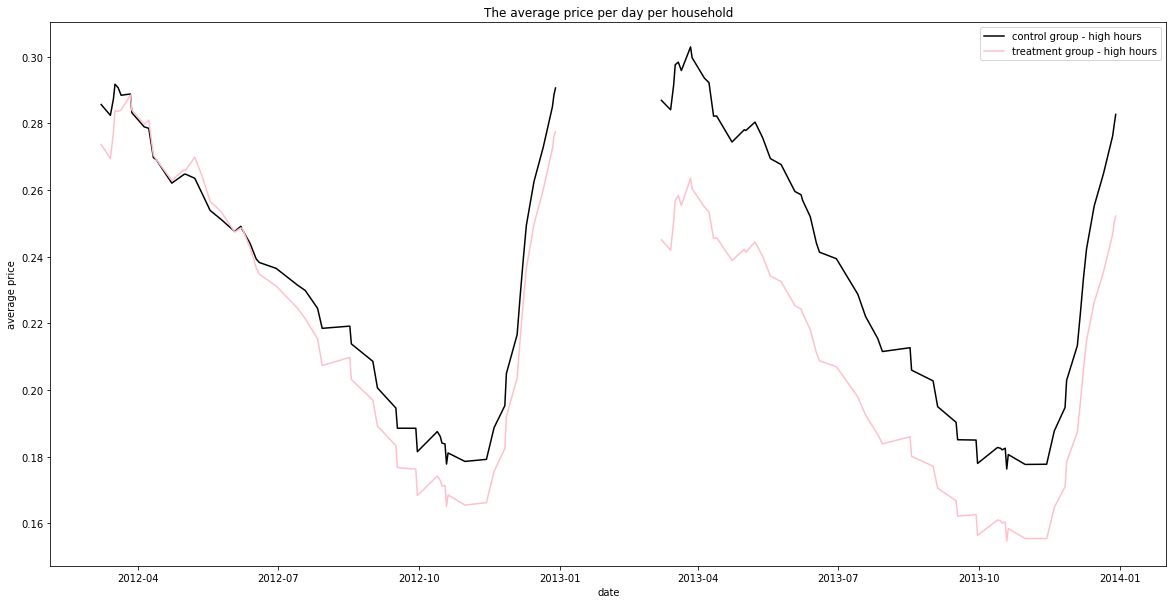

In [963]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(avg_consumption_perday_2012_control_high.rolling(20).mean(), color='black', label='control group - high hours')
ax.plot(avg_consumption_perday_2013_control_high.rolling(20).mean(), color='black')

# ax.plot(avg_consumption_perday_2012_control_normal.rolling(3).mean(), color='blue', label='control group - normal hours')
# ax.plot(avg_consumption_perday_2013_control_normal.rolling(3).mean(), color='blue')

# ax.plot(avg_consumption_perday_2012_control_low.rolling(3).mean(), color='green', label='control group - low hours')
# ax.plot(avg_consumption_perday_2013_control_low.rolling(3).mean(), color='green')

ax.plot(avg_consumption_perday_2012_treatment_high.rolling(20).mean(), color='pink', label='treatment group - high hours')
ax.plot(avg_consumption_perday_2013_treatment_high.rolling(20).mean(), color='pink')

# ax.plot(avg_consumption_perday_2012_treatment_normal.rolling(3).mean(), color='orange', label='treatment group - normal hours')
# ax.plot(avg_consumption_perday_2013_treatment_normal.rolling(3).mean(), color='orange')

# ax.plot(avg_consumption_perday_2012_treatment_low.rolling(3).mean(), color='red', label='treatment group - low hours')
# ax.plot(avg_consumption_perday_2013_treatment_low.rolling(3).mean(), color='red')

ax.legend(loc=1)
ax.set_xlabel('date')
ax.set_ylabel('average price')
ax.set_title('The average price per day per household');

In [448]:
# col = 'KWH/hh'
col = 'p/hh'

avg_consumption_perday_2012_treatment = find_mean_peryear(df_2012_treatment, col)
avg_consumption_perday_2012_control = find_mean_peryear(df_2012_control, col)
avg_consumption_perday_2013_treatment = find_mean_peryear(df_2013_treatment, col)
avg_consumption_perday_2013_control = find_mean_peryear(df_2013_control, col)

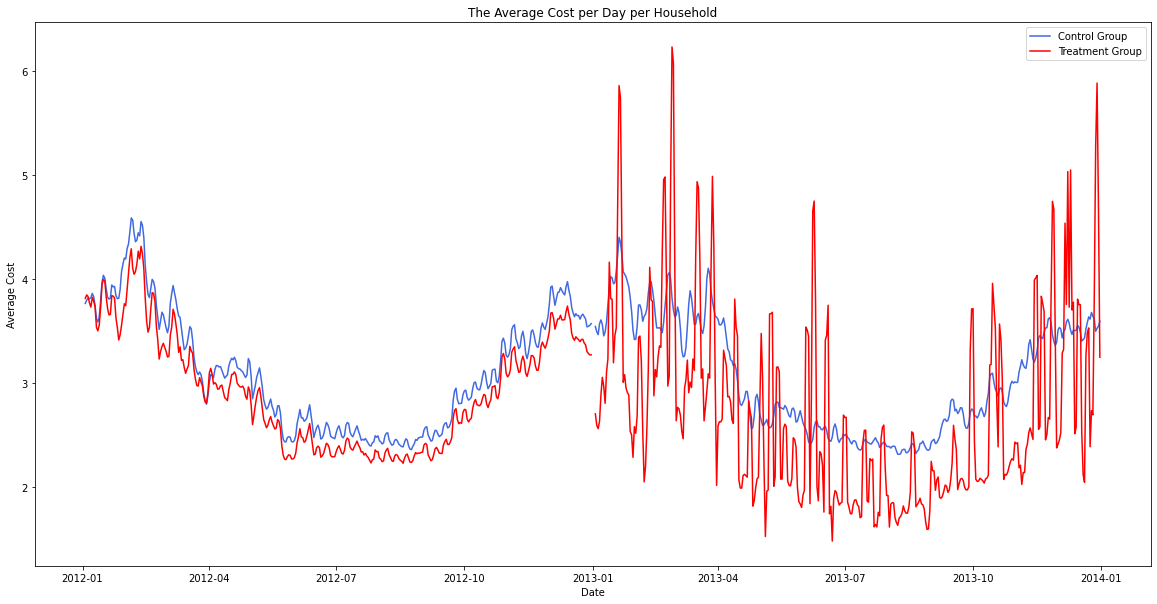

In [452]:
fig, ax = plt.subplots(figsize=(20, 10))

# 
ax.plot(avg_consumption_perday_2012_control.rolling(3).mean(), color='royalblue', label='Control Group')
ax.plot(avg_consumption_perday_2013_control.rolling(3).mean(), color='royalblue')

ax.plot(avg_consumption_perday_2012_treatment.rolling(3).mean(), color='red', label='Treatment Group')
ax.plot(avg_consumption_perday_2013_treatment.rolling(3).mean(), color='red')

ax.legend(loc=1)
ax.set_xlabel('Date')
ax.set_ylabel('Average Cost')
ax.set_title('The Average Cost per Day per Household')
fig.savefig('avg_cost_per_day.png');

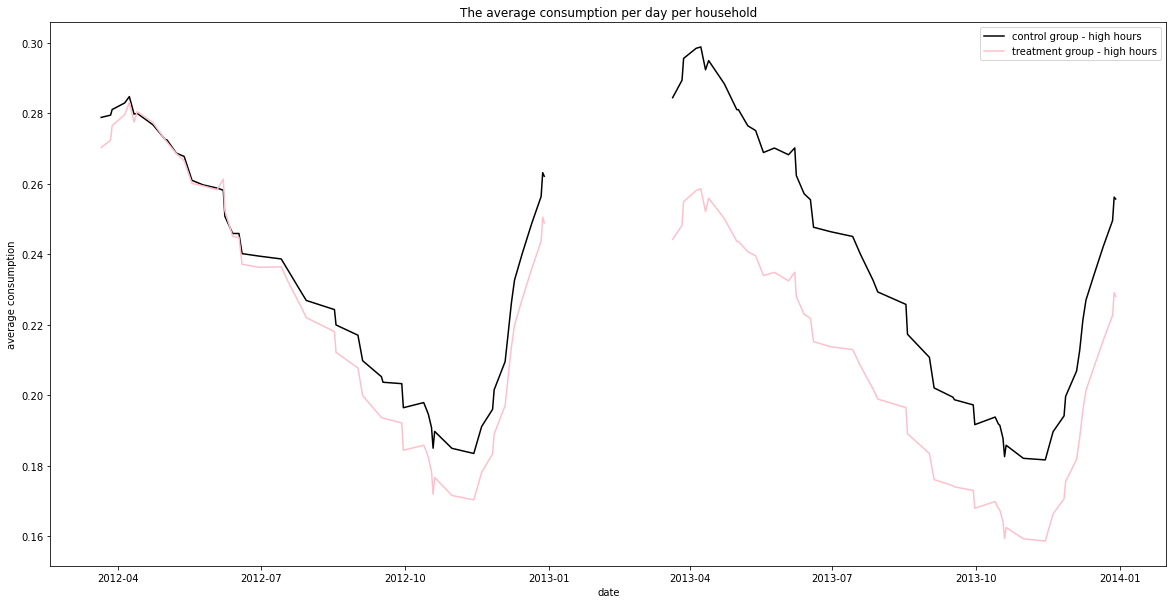

In [964]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(avg_consumption_perday_2012_control_high.rolling(25).mean(), color='black', label='control group - high hours')
ax.plot(avg_consumption_perday_2013_control_high.rolling(25).mean(), color='black')

# ax.plot(avg_consumption_perday_2012_control_normal.rolling(25).mean(), color='blue', label='control group - normal hours')
# ax.plot(avg_consumption_perday_2013_control_normal.rolling(25).mean(), color='blue')

# ax.plot(avg_consumption_perday_2012_control_low.rolling(25).mean(), color='green', label='control group - low hours')
# ax.plot(avg_consumption_perday_2013_control_low.rolling(25).mean(), color='green')

ax.plot(avg_consumption_perday_2012_treatment_high.rolling(25).mean(), color='pink', label='treatment group - high hours')
ax.plot(avg_consumption_perday_2013_treatment_high.rolling(25).mean(), color='pink')

# ax.plot(avg_consumption_perday_2012_treatment_normal.rolling(25).mean(), color='orange', label='treatment group - normal hours')
# ax.plot(avg_consumption_perday_2013_treatment_normal.rolling(25).mean(), color='orange')

# ax.plot(avg_consumption_perday_2012_treatment_low.rolling(25).mean(), color='red', label='treatment group - low hours')
# ax.plot(avg_consumption_perday_2013_treatment_low.rolling(25).mean(), color='red')

ax.legend(loc=1)
ax.set_xlabel('date')
ax.set_ylabel('average consumption')
ax.set_title('The average consumption per day per household');

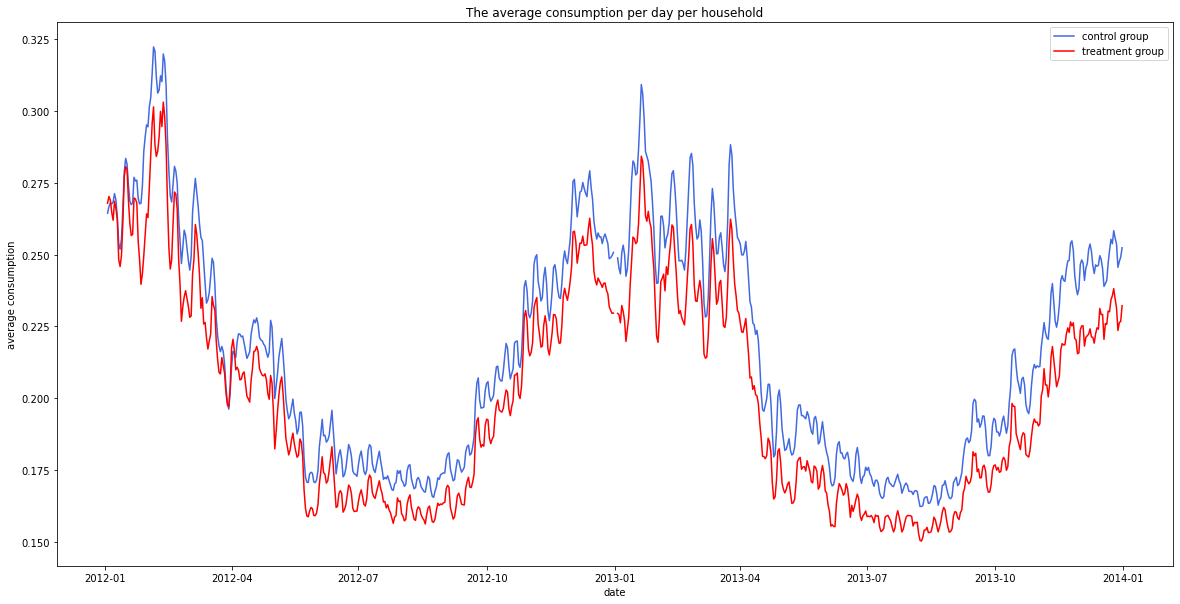

In [44]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(avg_consumption_perday_2012_control.rolling(3).mean(), color='royalblue', label='control group')
ax.plot(avg_consumption_perday_2013_control.rolling(3).mean(), color='royalblue')

ax.plot(avg_consumption_perday_2012_treatment.rolling(3).mean(), color='red', label='treatment group')
ax.plot(avg_consumption_perday_2013_treatment.rolling(3).mean(), color='red')

ax.legend(loc=1)
ax.set_xlabel('date')
ax.set_ylabel('average consumption')
ax.set_title('The average consumption per day per household');

In [338]:
l = [[0.207, 0.22], [0.191, 0.212], [0.201, 0.216], [0.243, 0.253], [0.197, 0.214], [0.197, 0.204], [0.19, 0.209], [0.221, 0.253]]
pd.DataFrame(l, index=['2012 overall', '2012 low', '2012 normal', '2012 high', '2013 overall', '2013 low', '2013 normal', '2013 high'], 
                    columns=['treatment', 'control'])

,treatment,control
2012 overall,0.207,0.220
2012 low,0.191,0.212
2012 normal,0.201,0.216
2012 high,0.243,0.253
2013 overall,0.197,0.214
2013 low,0.197,0.204
2013 normal,0.190,0.209
2013 high,0.221,0.253


In [361]:
# (2013-2012) / 2012
before = 0.243
after = 0.221
print(round((after - before), 3))
round((after - before)/before * 100, 2)

-0.022


-9.05

In [31]:
transform_KWH(0.243 - 0.221)

=  4.512820512820511 hours of TV
=  4.693333333333332 hours of fridge
=  4.141176470588234 hours of washing machine
=  0.3784946236559138 hours of dryer
=  0.3017142857142856 hours of AC


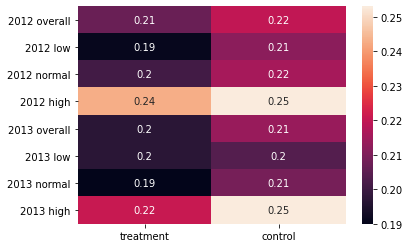

In [33]:
sns.heatmap(_29, annot=True);

In [ ]:
# mean over all days
# and compare across different years
print('the avg consumption per day in 2012 for the treatment group', avg_consumption_perday_2012_treatment)
print('the avg consumption per day in 2012 for the control group', avg_consumption_perday_2012_control)
print('the avg consumption per day in 2013 for the treatment group', avg_consumption_perday_2013_treatment)
print('the avg consumption per day in 2013 for the control group', avg_consumption_perday_2013_control)

In [12]:
a_, b_, a_2013_, b_2013_ = get_matrices(df_2012_treatment, df_2012_control, df_2013_treatment, df_2013_control)

(17520, 4404) (17520, 1112) (17520, 4404) (17520, 1112)


In [16]:
def get_error(house_id):
    test = b_[house_id].copy()
    percentage = []
    error = []
    for p in np.arange(0.05, 1, 0.05):
        masked = test.copy()
        masked[:math.floor(p*len(test))] = np.nan
        predicted_masked = masked.fillna(masked.median)
#         predicted_masked = masked.fillna(masked.mean())
        percentage.append(masked.isnull().sum()/len(test))
        error.append(((predicted_masked-test)**2).mean() / test.mean())
    return error, percentage

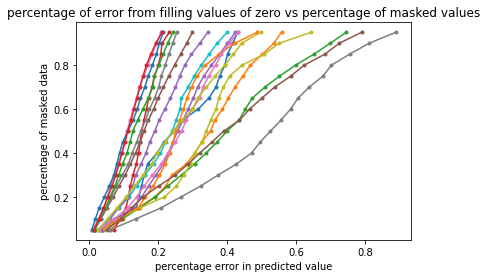

In [541]:
# zero
for h in ['MAC000048', 'MAC000064', 'MAC000071', 'MAC000075', 'MAC000106',
       'MAC000107', 'MAC000109', 'MAC000147', 'MAC000193', 'MAC000259',
       'MAC000261', 'MAC004456', 'MAC004467', 'MAC004485', 'MAC004491',
       'MAC004497', 'MAC004509', 'MAC004561', 'MAC004855']:
    error, percentage = get_error(h)
    plt.plot(error, percentage, label=h, marker='.')
    plt.xlabel('percentage error in predicted value')
    plt.ylabel('percentage of masked data')
    plt.title('percentage of error from filling values of zero vs percentage of masked values')

In [542]:
# i'm arbitrarily choosing 10% to be the cutoff, let's see on average, how much of the data I can impute
# zero
acceptable_masks = []
for h in ['MAC000048', 'MAC000064', 'MAC000071', 'MAC000075', 'MAC000106',
       'MAC000107', 'MAC000109', 'MAC000147', 'MAC000193', 'MAC000259',
       'MAC000261', 'MAC004456', 'MAC004467', 'MAC004485', 'MAC004491',
       'MAC004497', 'MAC004509', 'MAC004561', 'MAC004855']:
    error, percentage = get_error(h)
    for e, p in list(zip(error, percentage)):
        if e <= 0.1: 
            acceptable_masks.append(p)
statistics.mean(acceptable_masks)

0.1598880956974725

In [1013]:
# a_.isnull().sum() < 2 houses that have have zero or one missing data point (hh). this means the series is as complete as possible
# almost_complete_houses = a_.isnull().sum() < 2
# almost_complete_houses[almost_complete_houses].index
for h in ['MAC000048', 'MAC000064', 'MAC000071', 'MAC000075', 'MAC000106',
       'MAC000107', 'MAC000109', 'MAC000147', 'MAC000193', 'MAC000259',
       'MAC000261', 'MAC004456', 'MAC004467', 'MAC004485', 'MAC004491',
       'MAC004497', 'MAC004509', 'MAC004561', 'MAC004855']:
    error, percentage = get_error(h)
#     plt.figure(figsize=(16, 9))
    plt.plot(percentage, error, label=h, marker='.')
#     plt.legend(loc=1)
    plt.ylabel('percentage error in predicted value')
    plt.xlabel('percentage of masked data')
    plt.title(r'percentage of error from filling values vs percentage of masked values'
              '\n'
              r'over house_id')

TypeError: unsupported operand type(s) for -: 'method' and 'float'

In [533]:
def get_error_hh(hh):
    test = b_[b_.index == hh].squeeze().copy()
    percentage = []
    error = []
    for p in np.arange(0.05, 1, 0.05):
        masked = test.copy()
        masked[:math.floor(p*len(test))] = np.nan
        predicted_masked = masked.fillna(masked.median())
        percentage.append(masked.isnull().sum()/len(test))
        error.append(((predicted_masked-test)**2).mean() / test.mean())
    return error, percentage

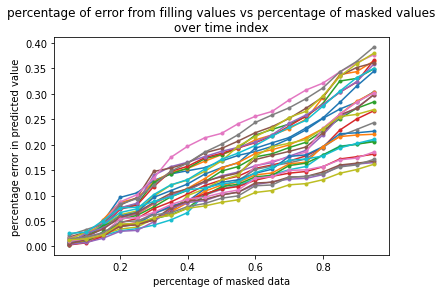

In [1005]:
# almost_complete_hh = a_.isnull().sum(axis=1) == 2
# almost_complete_hh[almost_complete_hh].index[:30]
for hh in ['2012-10-26 14:00:00', '2012-10-26 14:30:00',
'2012-10-26 15:00:00', '2012-10-26 15:30:00',
'2012-10-26 16:00:00', '2012-10-26 16:30:00',
'2012-10-26 17:00:00', '2012-10-26 17:30:00',
'2012-10-26 18:00:00', '2012-10-26 18:30:00',
'2012-10-26 19:00:00', '2012-10-26 19:30:00',
'2012-10-26 20:00:00', '2012-10-26 20:30:00',
'2012-10-26 21:00:00', '2012-10-26 21:30:00',
'2012-10-26 22:00:00', '2012-10-26 22:30:00',
'2012-10-26 23:00:00', '2012-10-26 23:30:00',
'2012-10-27 00:00:00', '2012-10-27 00:30:00',
'2012-10-27 01:00:00', '2012-10-27 02:00:00',
'2012-10-27 02:30:00', '2012-10-27 03:00:00',
'2012-10-27 03:30:00', '2012-10-27 04:00:00',
'2012-10-27 04:30:00', '2012-10-27 05:00:00']:
    error, percentage = get_error_hh(hh)
    plt.plot(percentage, error, label=h, marker='.')
#     plt.legend(loc=1)
    plt.ylabel('percentage error in predicted value')
    plt.xlabel('percentage of masked data')
    plt.title(r'percentage of error from filling values vs percentage of masked values'
              '\n'
              r'over time index')

In [535]:
acceptable_masks = []
for hh in ['2012-10-26 14:00:00', '2012-10-26 14:30:00',
'2012-10-26 15:00:00', '2012-10-26 15:30:00',
'2012-10-26 16:00:00', '2012-10-26 16:30:00',
'2012-10-26 17:00:00', '2012-10-26 17:30:00',
'2012-10-26 18:00:00', '2012-10-26 18:30:00',
'2012-10-26 19:00:00', '2012-10-26 19:30:00',
'2012-10-26 20:00:00', '2012-10-26 20:30:00',
'2012-10-26 21:00:00', '2012-10-26 21:30:00',
'2012-10-26 22:00:00', '2012-10-26 22:30:00',
'2012-10-26 23:00:00', '2012-10-26 23:30:00',
'2012-10-27 00:00:00', '2012-10-27 00:30:00',
'2012-10-27 01:00:00', '2012-10-27 02:00:00',
'2012-10-27 02:30:00', '2012-10-27 03:00:00',
'2012-10-27 03:30:00', '2012-10-27 04:00:00',
'2012-10-27 04:30:00', '2012-10-27 05:00:00']:
    error, percentage = get_error_hh(hh)
    for e, p in list(zip(error, percentage)):
        if e <= 0.1: 
            acceptable_masks.append(p)
print(statistics.mean(acceptable_masks))

0.21066944521306033


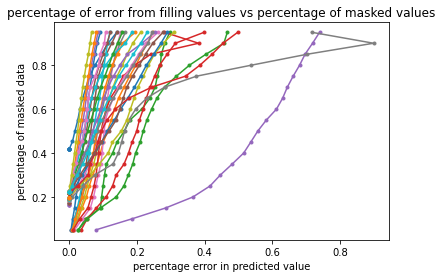

In [260]:
# almost_complete_houses = a_2013_.isnull().sum() < 2
# almost_complete_houses[almost_complete_houses].index[:30]
for h in ['MAC000005', 'MAC000044', 'MAC000048', 'MAC000064', 'MAC000082',
       'MAC000088', 'MAC000106', 'MAC000107', 'MAC000141', 'MAC000147',
       'MAC000165', 'MAC000187', 'MAC000193', 'MAC000198', 'MAC000286',
       'MAC000303', 'MAC000352', 'MAC000354', 'MAC000366', 'MAC000369',
       'MAC000383', 'MAC000395', 'MAC000406', 'MAC000418', 'MAC000433',
       'MAC000439', 'MAC000447', 'MAC000461', 'MAC000464', 'MAC000478']:
    error, percentage = get_error(h)
    plt.plot(error, percentage, label=h, marker='.')
#     plt.legend(loc=1)
    plt.xlabel('percentage error in predicted value')
    plt.ylabel('percentage of masked data')
    plt.title('percentage of error from filling values vs percentage of masked values')

In [538]:
# i'm arbitrarily choosing 10% to be the cutoff, let's see on average, how much of the data I can impute
acceptable_masks = []
for h in ['MAC000048', 'MAC000064', 'MAC000071', 'MAC000075', 'MAC000106',
       'MAC000107', 'MAC000109', 'MAC000147', 'MAC000193', 'MAC000259',
       'MAC000261', 'MAC004456', 'MAC004467', 'MAC004485', 'MAC004491',
       'MAC004497', 'MAC004509', 'MAC004561', 'MAC004855']:
    error, percentage = get_error(h)
    for e, p in list(zip(error, percentage)):
        if e <= 0.1: 
            acceptable_masks.append(p)
    statistics.mean(acceptable_masks)

In [539]:
statistics.mean(acceptable_masks)

0.34248105915665417

Something to look into later is instead of imputing using a single mean value, i can take the mean of two surrounding values of nans and see if that would help

In [225]:
n = 0

a_2013_train_sliced = impute(a_2013_train_sliced.iloc[n:, :].values, np.nanmedian, 1)
a_2013_test_sliced = impute(a_2013_test_sliced.iloc[n:, :].values, np.nanmedian, 1)
a_2014_train = impute(a_2014_train.iloc[n:, :].values, np.nanmedian, 1)
a_2014_test = impute(a_2014_test.iloc[n:, :].values, np.nanmedian, 1)

In [51]:
# divide along columns by default
# train_size between 0-100%
def test_train_split(df, train_size, axis=1):
    all_columns = set(df.columns)
    train = set(random.sample(all_columns, math.floor(train_size * len(all_columns))))
    test = all_columns - train
    return df.loc[:, df.columns.isin(train)], df.loc[:, df.columns.isin(test)]

In [224]:
train_size = 0.66

a_2013_train_sliced, a_2013_test_sliced = test_train_split(a_2013_sliced_dropped, train_size)
# b_2013_train_sliced, b_2013_test_sliced = test_train_split(b_2013_sliced_, train_size)
a_2014_train, a_2014_test = test_train_split(a_2014_, train_size)
# b_2014_train, b_2014_test = test_train_split(b_2014_, train_size)

<AxesSubplot:xlabel='house_id'>

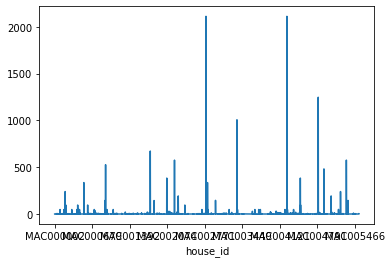

In [237]:
a_2013_sliced_.isna().sum(axis=0).plot()

<AxesSubplot:xlabel='date_time'>

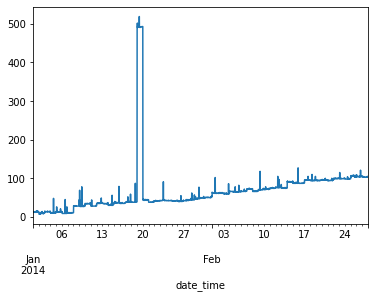

In [205]:
a_2014_.isna().sum(axis=1).plot()

In [188]:
# a_2012_train_inv = np.linalg.pinv(a_2012_train)
# a_2012_test_inv = np.linalg.pinv(a_2012_test)
a_2013_train_sliced_imputed_inv = np.linalg.pinv(a_2013_train_sliced_imputed)
# a_2013_test_inv = np.linalg.pinv(a_2013_test)

In [199]:
a_2013_test_sliced @ X

array([[ -2.56829703,  -5.07564472,  -7.39009865, ..., -12.42216353,
        -11.89151039,  -6.85152641],
       [ -0.17306766,   0.18448718,  -0.13611744, ...,  -1.80958448,
         -2.07851   ,  -0.81871768],
       [ -6.8914193 ,  -6.50836296,  -5.11140062, ...,  -7.13682479,
         -8.74806269,  -5.89901795],
       ...,
       [ -7.32282354,  -7.15403222, -11.25999866, ...,  -4.59193565,
         -7.4348063 ,  -5.96913927],
       [  4.7180686 ,   4.17796775,   6.30909696, ...,   2.89674124,
          3.69225302,   3.7336579 ],
       [  1.31794648,   1.72483613,   0.99218741, ...,   4.25116422,
          2.75851426,   1.2442679 ]])

In [201]:
mean_squared_error(a_2014_test.flatten(), _199.flatten())

49.49133285242633

In [27]:
mean_squared_error(a_2013_test.flatten(), _21.flatten())

0.11353054097447966

In [56]:
# so let's see how bad this data looks: 
(a_.sum(axis=0) < 2000).sum()

2482

In [58]:
(a_2013.sum(axis=0) < 2000).sum()

1091

In [62]:
total_usage_2013.groupby(['house_id', 'treated'])['KWH/hh'].sum()

house_id   treated
MAC000002  False      4217.564000
MAC000003  False      7029.262004
MAC000004  False       618.747000
MAC000005  True       1654.288000
MAC000006  False      1054.243000
                         ...     
MAC005561  False      2682.460000
MAC005562  False      4038.898000
MAC005564  True       1424.624999
MAC005566  False      7635.814999
MAC005567  False      1902.001999
Name: KWH/hh, Length: 5528, dtype: float64

In [25]:
u, s, v = np.linalg.svd(a)

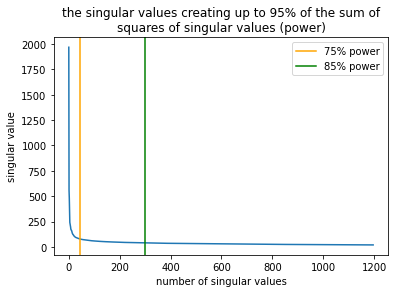

In [61]:
plt.plot(s[:find_top_components(s, 0.95)])
plt.axvline(find_top_components(s, 0.75), color='orange', label='75% power')
plt.axvline(find_top_components(s, 0.85), color='green', label='85% power')
plt.xlabel('number of singular values')
plt.ylabel('singular value')
plt.title(r'the singular values creating up to 95% of the sum of'
          '\n'
          r'squares of singular values (power)')
plt.legend()
plt.show()

In [458]:
# option 1
# extract the low rank structure, look at singular values see if you see a cutoff threashod
# u, s, v = np.linalg.svd(a)
# v = v.T

# n_component = find_top_components(s)

# up = u[:, :n_component]
# sp = s[:n_component]
# vp = v[:n_component, :]

# a_inv_tilde = (vp.T @ np.linalg.inv(np.diag(sp))) @ up.T
a_inv = np.linalg.pinv(a)

# x_tilde = a_inv_tilde @ b
x_tilde = a_inv @ b

b_2013_tilde = a_2013 @ x_tilde

# b_2013_ = pd.DataFrame(b_2013, columns=b_2013_.iloc[n:, :].columns, index=b_2013_.iloc[n:, :].index)
# b_2013_tilde_ = pd.DataFrame(b_2013_tilde, columns=b_2013_.iloc[n:, :].columns, index=b_2013_.iloc[n:, :].index)

In [461]:
b_2013_tilde[b_2013_tilde<0] = 0

In [465]:
delta = b_2013 - b_2013_tilde

fraction_lowered = delta / b_2013_tilde # percent improvement

<ipython-input-465-d0b8c4ed20a3>:3: RuntimeWarning: divide by zero encountered in true_divide
  fraction_lowered = delta / b_2013_tilde # percent improvement
<ipython-input-465-d0b8c4ed20a3>:3: RuntimeWarning: invalid value encountered in true_divide
  fraction_lowered = delta / b_2013_tilde # percent improvement


In [840]:
(b_2013_tilde < 0).sum() / b_2013_tilde.size

0.16471689087086494

In [467]:
np.mean(b_2013), np.mean(b_2013_tilde), np.mean(delta)

(0.19428717487929034, 0.2162986294250219, -0.022011454545732032)

In [468]:
np.median(b_2013), np.median(b_2013_tilde), np.median(delta)

(0.11, 0.1369548204198756, -0.010452532871939296)

In [461]:
# b_2013_high = b_2013_[b_2013_.index.isin(highs)]
# b_2013_tilde_high = b_2013_tilde_[b_2013_tilde_.index.isin(highs)]
print((b_2013_high - b_2013_tilde_high).mean().mean() / b_2013_high.mean().mean())

# b_2013_normal = b_2013_[b_2013_.index.isin(normals)]
# b_2013_tilde_normal = b_2013_tilde_[b_2013_tilde_.index.isin(normals)]
print((b_2013_normal - b_2013_tilde_normal).mean().mean() / b_2013_normal.mean().mean())

# b_2013_low = b_2013_[b_2013_.index.isin(lows)]
# b_2013_tilde_low = b_2013_tilde_[b_2013_tilde_.index.isin(lows)]
print((b_2013_low - b_2013_tilde_low).mean().mean() / b_2013_low.mean().mean())

-0.07233813926026937
-0.015069206770055204
0.04685808864988666


In [753]:
b_2013_high = b_2013_[b_2013_.index.isin(highs)]
b_2013_tilde_high = b_2013_tilde_[b_2013_tilde_.index.isin(highs)]
print(np.median((b_2013_high - b_2013_tilde_high) / b_2013_tilde_high))

b_2013_normal = b_2013_[b_2013_.index.isin(normals)]
b_2013_tilde_normal = b_2013_tilde_[b_2013_tilde_.index.isin(normals)]
print(np.median((b_2013_normal - b_2013_tilde_normal) / b_2013_tilde_normal))

b_2013_low = b_2013_[b_2013_.index.isin(lows)]
b_2013_tilde_low = b_2013_tilde_[b_2013_tilde_.index.isin(lows)]
print(np.median((b_2013_low - b_2013_tilde_low) / b_2013_tilde_low))

-0.43562555206422326
-0.4344211798386103
-0.4415517141487608


In [757]:
b_2013_high_affluent = b_2013_.loc[b_2013_.index.isin(highs), b_2013_.columns.isin(affluent)]
b_2013_tilde_high_affluent = b_2013_tilde_.loc[b_2013_tilde_.index.isin(highs), b_2013_tilde_.columns.isin(affluent)]
np.median((b_2013_high_affluent - b_2013_tilde_high_affluent) / b_2013_tilde_high_affluent)

-0.4770235446190627

In [745]:
b_2013_high_comfortable = b_2013_.loc[b_2013_.index.isin(highs), b_2013_.columns.isin(comfortable)]
b_2013_tilde_high_comfortable = b_2013_tilde_.loc[b_2013_tilde_.index.isin(highs), b_2013_tilde_.columns.isin(comfortable)]
np.median((b_2013_high_comfortable - b_2013_tilde_high_comfortable) / b_2013_tilde_high_comfortable)

-0.38939418077644306

In [748]:
b_2013_high_adversity = b_2013_.loc[b_2013_.index.isin(highs), b_2013_.columns.isin(adversity)]
b_2013_tilde_high_adversity = b_2013_tilde_.loc[b_2013_tilde_.index.isin(highs), b_2013_tilde_.columns.isin(adversity)]
np.median((b_2013_high_adversity - b_2013_tilde_high_adversity) / b_2013_tilde_high_adversity)

-0.4203363707049543

In [456]:
b_2013_normal_affluent = b_2013_.loc[b_2013_.index.isin(normals), b_2013_.columns.isin(affluent)]
b_2013_tilde_normal_affluent = b_2013_tilde_.loc[b_2013_tilde_.index.isin(normals), b_2013_tilde_.columns.isin(affluent)]
print((b_2013_normal_affluent - b_2013_tilde_normal_affluent).mean().mean() / b_2013_tilde_normal_affluent.mean().mean())

b_2013_normal_comfortable = b_2013_.loc[b_2013_.index.isin(normals), b_2013_.columns.isin(comfortable)]
b_2013_tilde_normal_comfortable = b_2013_tilde_.loc[b_2013_tilde_.index.isin(normals), b_2013_tilde_.columns.isin(comfortable)]
print((b_2013_normal_comfortable - b_2013_tilde_normal_comfortable).mean().mean() / b_2013_tilde_normal_comfortable.mean().mean())

b_2013_normal_adversity = b_2013_.loc[b_2013_.index.isin(normals), b_2013_.columns.isin(adversity)]
b_2013_tilde_normal_adversity = b_2013_tilde_.loc[b_2013_tilde_.index.isin(normals), b_2013_tilde_.columns.isin(adversity)]
print((b_2013_normal_adversity - b_2013_tilde_normal_adversity).mean().mean() / b_2013_tilde_normal_adversity.mean().mean())

-0.02631277859047642
0.007572411521144922
-0.020839533311427228


In [457]:
b_2013_low_affluent = b_2013_.loc[b_2013_.index.isin(lows), b_2013_.columns.isin(affluent)]
b_2013_tilde_low_affluent = b_2013_tilde_.loc[b_2013_tilde_.index.isin(lows), b_2013_tilde_.columns.isin(affluent)]
print((b_2013_low_affluent - b_2013_tilde_low_affluent).mean().mean() / b_2013_low_affluent.mean().mean())

b_2013_low_comfortable = b_2013_.loc[b_2013_.index.isin(lows), b_2013_.columns.isin(comfortable)]
b_2013_tilde_low_comfortable = b_2013_tilde_.loc[b_2013_tilde_.index.isin(lows), b_2013_tilde_.columns.isin(comfortable)]
print((b_2013_low_comfortable - b_2013_tilde_low_comfortable).mean().mean() / b_2013_low_comfortable.mean().mean())

b_2013_low_adversity = b_2013_.loc[b_2013_.index.isin(lows), b_2013_.columns.isin(adversity)]
b_2013_tilde_low_adversity = b_2013_tilde_.loc[b_2013_tilde_.index.isin(lows), b_2013_tilde_.columns.isin(adversity)]
print((b_2013_low_adversity - b_2013_tilde_low_adversity).mean().mean() / b_2013_low_adversity.mean().mean())

0.022016338381704147
0.08803643255244345
0.04834302139081085


In [446]:
high_test_dist = list((b_2013_high - b_2013_tilde_high).mean(axis=1) / b_2013_tilde_high.mean(axis=1))

In [454]:
(b_2013_high - b_2013_tilde_high).mean(axis=0).mean() / b_2013_tilde_high.mean(axis=0).mean()

-0.06742115433158911

In [450]:
statistics.mean(high_test_dist)

-0.062298270214928404

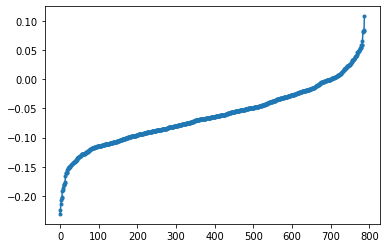

In [447]:
plt.plot(sorted(high_test_dist), marker='.')

In [496]:
# a_2013_.loc[b_2013_.index.isin(highs), b_2013_.columns.isin(affluent)]

In [707]:
# option 2
x_tilde2 = a_inv @ a_2013

b_2013_tilde2 = b @ x_tilde2

delta = b_2013 - b_2013_tilde2

fraction_lowered = delta / b_2013_tilde2

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4404 is different from 1112)

In [373]:
# dropped all nans
delta.mean() / b_2013_tilde.mean()

0.31115816711900957

In [330]:
# cut, imputed, cut
delta.mean() / b_2013_tilde.mean()

0.27830646210777343

In [306]:
# cut, zeros
delta.mean() / b_2013_tilde.mean()

0.057650031009248794

In [260]:
# uncut, imputed
delta.mean() / b_2013_tilde.mean()

0.008948630465673046

In [257]:
# uncut, zeros
delta.mean() / b_2013_tilde.mean()

0.529476674946609

In [ ]:
# cross-validation

a = a.T
a_2013 = a_2013.T

a_test = a[:math.floor(len(a)*0.2)]
a_train = a[math.floor(len(a)*0.8):]
a_2013_test = a_2013[:math.floor(len(a_2013)*0.2)]
a_2013_train = a_2013[math.floor(len(a_2013)*0.8):]
u, s, v = np.linalg.svd(a_train)

n_component = find_top_components(s)

up = u[:, :n_component]
sp = s[:n_component]
vp = v[:n_component, :]

a_train_inv_tilde = (vp.T @ np.linalg.inv(np.diag(sp))) @ up.T

x_tilde = a_train_inv_tilde @ a_2013_train.to_numpy()

In [377]:
len(set(df_2014_control['house_id']).intersection(set(df_2012_control['house_id'])))

4058

In [ ]:
df_2012_control.merge(df_2014_control, on='house_id', how='outer')

## Aggregated Linear Regression ##

In [ ]:
y_pred_2013['p/hh'] = y_pred_2013['y_pred_2013'] * tariffs['p/kWh']

In [1028]:
mean_over_houses_per_hh_price_2012_affluent = mean_over_houses_per_hh_price(total_usage_2012_affluent)
mean_over_houses_per_hh_price_2013_affluent = mean_over_houses_per_hh_price(total_usage_2013_affluent)

mean_over_houses_per_hh_price_2012_comfortable = mean_over_houses_per_hh_price(total_usage_2012_comfortable)
mean_over_houses_per_hh_price_2013_comfortable = mean_over_houses_per_hh_price(total_usage_2013_comfortable)

mean_over_houses_per_hh_price_2012_adversity = mean_over_houses_per_hh_price(total_usage_2012_adversity)
mean_over_houses_per_hh_price_2013_adversity = mean_over_houses_per_hh_price(total_usage_2013_adversity)

In [1042]:
mean_over_houses_per_hh_price_2012 = mean_over_houses_per_hh_price(total_usage_2012)
mean_over_houses_per_hh_price_2013 = mean_over_houses_per_hh_price(total_usage_2013)

In [921]:
delta_linreg = -(Y_pred_2013.T[0] - mean_over_houses_per_hh_2013['KWH/hh', True].values)/Y_pred_2013.T[0]
delta_linreg_affluent = -(Y_pred_2013.T[0] - mean_over_houses_per_hh_2013_affluent['KWH/hh', True].values)/Y_pred_2013.T[0]
delta_linreg_comfortable = -(Y_pred_2013.T[0] - mean_over_houses_per_hh_2013_comfortable['KWH/hh', True].values)/Y_pred_2013.T[0]
delta_linreg_adversity = -(Y_pred_2013.T[0] - mean_over_houses_per_hh_2013_adversity['KWH/hh', True].values)/Y_pred_2013.T[0]

In [892]:
y_pred_2013 = pd.DataFrame(Y_pred_2013.T[0], index=mean_over_houses_per_hh_2013.index, columns=['y_pred_2013'])

In [1064]:
mean_over_houses_per_hh_price_2013_affluent

treated,False,True
date_time,,
2013-01-01 00:00:00,4.243495,2.796916
2013-01-01 00:30:00,3.880947,2.580605
2013-01-01 01:00:00,3.557490,2.365457
2013-01-01 01:30:00,3.312309,2.219827
2013-01-01 02:00:00,3.066967,2.050605
...,...,...
2013-12-31 21:30:00,4.994919,3.993593
2013-12-31 22:00:00,4.676182,3.818407
2013-12-31 22:30:00,4.544547,3.597397


In [1062]:
y_pred_2013[y_pred_2013.index.isin(highs)]

,y_pred_2013,p/hh
date_time,,
2013-01-07 23:00:00,0.260000,17.472032
2013-01-07 23:30:00,0.215862,14.505955
2013-01-08 00:00:00,0.219087,14.722665
2013-01-08 00:30:00,0.191388,12.861278
2013-01-08 01:00:00,0.165319,11.109468
...,...,...
2013-12-29 02:30:00,0.137683,9.252281
2013-12-29 03:00:00,0.127258,8.551758
2013-12-29 03:30:00,0.121924,8.193310


In [1080]:
(-(y_pred_2013[y_pred_2013.index.isin(highs)]['p/hh'] - mean_over_houses_per_hh_price_2013
                                   [mean_over_houses_per_hh_price_2013.index.isin(highs)][True])/y_pred_2013[y_pred_2013.index.isin(highs)]['p/hh']).mean()

-0.07477545133001778

In [1068]:
(-(y_pred_2013[y_pred_2013.index.isin(highs)]['y_pred_2013'] - mean_over_houses_per_hh_2013_adversity
                                   [mean_over_houses_per_hh_2013_adversity.index.isin(highs)]['KWH/hh', True])/y_pred_2013[y_pred_2013.index.isin(highs)]['y_pred_2013']).mean()

-0.21546083066035476

In [1073]:
delta_linreg_price = -(y_pred_2013['p/hh'] - mean_over_houses_per_hh_price_2013[True].values)/y_pred_2013['p/hh']
delta_linreg_price_affluent = -(y_pred_2013['p/hh'] - mean_over_houses_per_hh_price_2013_affluent[True].values)/y_pred_2013['p/hh']
delta_linreg_price_comfortable = -(y_pred_2013['p/hh'] - mean_over_houses_per_hh_price_2013_comfortable[True].values)/y_pred_2013['p/hh']
delta_linreg_price_adversity = -(y_pred_2013['p/hh'] - mean_over_houses_per_hh_price_2013_adversity[True].values)/y_pred_2013['p/hh']

delta_linreg_price_affluent_low = -(y_pred_2013[y_pred_2013.index.isin(lows)]['p/hh'] - mean_over_houses_per_hh_price_2013_affluent
                                 [mean_over_houses_per_hh_price_2013_affluent.index.isin(lows)][True])/y_pred_2013[y_pred_2013.index.isin(lows)]['p/hh']
delta_linreg_price_affluent_normal = -(y_pred_2013[y_pred_2013.index.isin(normals)]['p/hh'] - mean_over_houses_per_hh_price_2013_affluent
                                    [mean_over_houses_per_hh_price_2013_affluent.index.isin(normals)][True])/y_pred_2013[y_pred_2013.index.isin(normals)]['p/hh']
delta_linreg_price_affluent_high = -(y_pred_2013[y_pred_2013.index.isin(highs)]['p/hh'] - mean_over_houses_per_hh_price_2013_affluent
                                   [mean_over_houses_per_hh_price_2013_affluent.index.isin(highs)][True])/y_pred_2013[y_pred_2013.index.isin(highs)]['p/hh']

delta_linreg_price_comfortable_low = -(y_pred_2013[y_pred_2013.index.isin(lows)]['p/hh'] - mean_over_houses_per_hh_price_2013_comfortable
                                 [mean_over_houses_per_hh_price_2013_comfortable.index.isin(lows)][True])/y_pred_2013[y_pred_2013.index.isin(lows)]['p/hh']
delta_linreg_price_comfortable_normal = -(y_pred_2013[y_pred_2013.index.isin(normals)]['p/hh'] - mean_over_houses_per_hh_price_2013_comfortable
                                    [mean_over_houses_per_hh_price_2013_comfortable.index.isin(normals)][True])/y_pred_2013[y_pred_2013.index.isin(normals)]['p/hh']
delta_linreg_price_comfortable_high = -(y_pred_2013[y_pred_2013.index.isin(highs)]['p/hh'] - mean_over_houses_per_hh_price_2013_comfortable
                                   [mean_over_houses_per_hh_price_2013_comfortable.index.isin(highs)][True])/y_pred_2013[y_pred_2013.index.isin(highs)]['p/hh']

delta_linreg_price_adversity_low = -(y_pred_2013[y_pred_2013.index.isin(lows)]['p/hh'] - mean_over_houses_per_hh_price_2013_adversity
                                 [mean_over_houses_per_hh_price_2013_adversity.index.isin(lows)][True])/y_pred_2013[y_pred_2013.index.isin(lows)]['p/hh']
delta_linreg_price_adversity_normal = -(y_pred_2013[y_pred_2013.index.isin(normals)]['p/hh'] - mean_over_houses_per_hh_price_2013_adversity
                                    [mean_over_houses_per_hh_price_2013_adversity.index.isin(normals)][True])/y_pred_2013[y_pred_2013.index.isin(normals)]['p/hh']
delta_linreg_price_adversity_high = -(y_pred_2013[y_pred_2013.index.isin(highs)]['p/hh'] - mean_over_houses_per_hh_price_2013_adversity
                                   [mean_over_houses_per_hh_price_2013_adversity.index.isin(highs)][True])/y_pred_2013[y_pred_2013.index.isin(highs)]['p/hh']

delta_linreg_price_low = -(y_pred_2013[y_pred_2013.index.isin(lows)]['p/hh'] - mean_over_houses_per_hh_price_2013
                                 [mean_over_houses_per_hh_price_2013.index.isin(lows)][True])/y_pred_2013[y_pred_2013.index.isin(lows)]['p/hh']
delta_linreg_price_normal = -(y_pred_2013[y_pred_2013.index.isin(normals)]['p/hh'] - mean_over_houses_per_hh_price_2013
                                    [mean_over_houses_per_hh_price_2013.index.isin(normals)][True])/y_pred_2013[y_pred_2013.index.isin(normals)]['p/hh']
delta_linreg_price_high = -(y_pred_2013[y_pred_2013.index.isin(highs)]['p/hh'] - mean_over_houses_per_hh_price_2013
                                   [mean_over_houses_per_hh_price_2013.index.isin(highs)][True])/y_pred_2013[y_pred_2013.index.isin(highs)]['p/hh']

In [950]:
delta_linreg_low = -(y_pred_2013[y_pred_2013.index.isin(lows)]['y_pred_2013'] - mean_over_houses_per_hh_2013
                                 [mean_over_houses_per_hh_2013.index.isin(lows)]['KWH/hh', True])/y_pred_2013[y_pred_2013.index.isin(lows)]['y_pred_2013']
delta_linreg_normal = -(y_pred_2013[y_pred_2013.index.isin(normals)]['y_pred_2013'] - mean_over_houses_per_hh_2013
                                    [mean_over_houses_per_hh_2013.index.isin(normals)]['KWH/hh', True])/y_pred_2013[y_pred_2013.index.isin(normals)]['y_pred_2013']
delta_linreg_high = -(y_pred_2013[y_pred_2013.index.isin(highs)]['y_pred_2013'] - mean_over_houses_per_hh_2013
                                   [mean_over_houses_per_hh_2013.index.isin(highs)]['KWH/hh', True])/y_pred_2013[y_pred_2013.index.isin(highs)]['y_pred_2013']


In [944]:
delta_linreg_affluent_low = -(y_pred_2013[y_pred_2013.index.isin(lows)]['y_pred_2013'] - mean_over_houses_per_hh_2013_affluent
                                 [mean_over_houses_per_hh_2013_affluent.index.isin(lows)]['KWH/hh', True])/y_pred_2013[y_pred_2013.index.isin(lows)]['y_pred_2013']
delta_linreg_affluent_normal = -(y_pred_2013[y_pred_2013.index.isin(normals)]['y_pred_2013'] - mean_over_houses_per_hh_2013_affluent
                                    [mean_over_houses_per_hh_2013_affluent.index.isin(normals)]['KWH/hh', True])/y_pred_2013[y_pred_2013.index.isin(normals)]['y_pred_2013']
delta_linreg_affluent_high = -(y_pred_2013[y_pred_2013.index.isin(highs)]['y_pred_2013'] - mean_over_houses_per_hh_2013_affluent
                                   [mean_over_houses_per_hh_2013_affluent.index.isin(highs)]['KWH/hh', True])/y_pred_2013[y_pred_2013.index.isin(highs)]['y_pred_2013']

delta_linreg_comfortable_low = -(y_pred_2013[y_pred_2013.index.isin(lows)]['y_pred_2013'] - mean_over_houses_per_hh_2013_comfortable
                                 [mean_over_houses_per_hh_2013_comfortable.index.isin(lows)]['KWH/hh', True])/y_pred_2013[y_pred_2013.index.isin(lows)]['y_pred_2013']
delta_linreg_comfortable_normal = -(y_pred_2013[y_pred_2013.index.isin(normals)]['y_pred_2013'] - mean_over_houses_per_hh_2013_comfortable
                                    [mean_over_houses_per_hh_2013_comfortable.index.isin(normals)]['KWH/hh', True])/y_pred_2013[y_pred_2013.index.isin(normals)]['y_pred_2013']
delta_linreg_comfortable_high = -(y_pred_2013[y_pred_2013.index.isin(highs)]['y_pred_2013'] - mean_over_houses_per_hh_2013_comfortable
                                   [mean_over_houses_per_hh_2013_comfortable.index.isin(highs)]['KWH/hh', True])/y_pred_2013[y_pred_2013.index.isin(highs)]['y_pred_2013']

delta_linreg_adversity_low = -(y_pred_2013[y_pred_2013.index.isin(lows)]['y_pred_2013'] - mean_over_houses_per_hh_2013_adversity
                                 [mean_over_houses_per_hh_2013_adversity.index.isin(lows)]['KWH/hh', True])/y_pred_2013[y_pred_2013.index.isin(lows)]['y_pred_2013']
delta_linreg_adversity_normal = -(y_pred_2013[y_pred_2013.index.isin(normals)]['y_pred_2013'] - mean_over_houses_per_hh_2013_adversity
                                    [mean_over_houses_per_hh_2013_adversity.index.isin(normals)]['KWH/hh', True])/y_pred_2013[y_pred_2013.index.isin(normals)]['y_pred_2013']
delta_linreg_adversity_price_high = -(y_pred_2013[y_pred_2013.index.isin(highs)]['y_pred_2013'] - mean_over_houses_per_hh_2013_adversity
                                   [mean_over_houses_per_hh_2013_adversity.index.isin(highs)]['KWH/hh', True])/y_pred_2013[y_pred_2013.index.isin(highs)]['y_pred_2013']

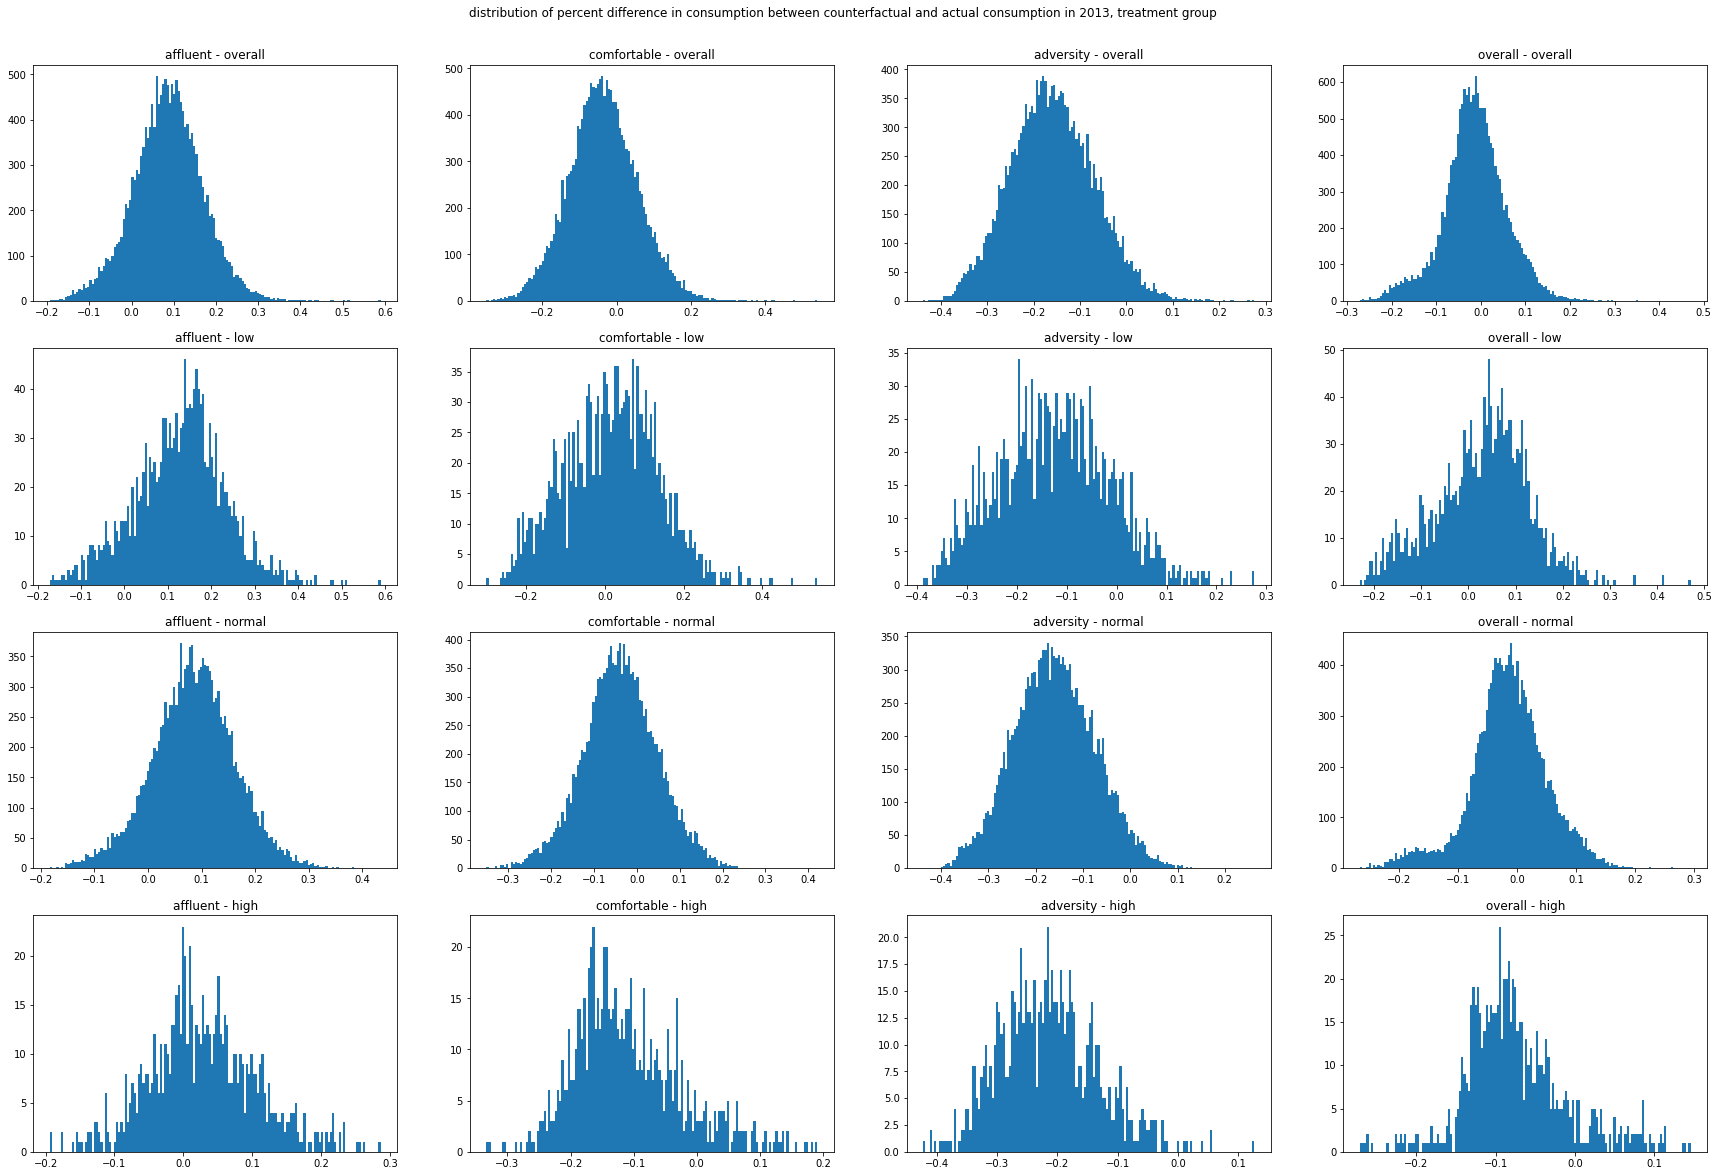

In [1049]:
fig, axs = plt.subplots(4, 4, figsize=(30, 20))

axs[0, 0].hist(delta_linreg_affluent, bins=150)
axs[0, 0].set_title('affluent - overall')
axs[0, 1].hist(delta_linreg_comfortable, bins=150)
axs[0, 1].set_title('comfortable - overall')
axs[0, 2].hist(delta_linreg_adversity, bins=150)
axs[0, 2].set_title('adversity - overall')
axs[0, 3].hist(delta_linreg, bins=150)
axs[0, 3].set_title('overall - overall')


axs[1, 0].hist(delta_linreg_affluent_low, bins=150)
axs[1, 0].set_title('affluent - low')
axs[1, 1].hist(delta_linreg_comfortable_low, bins=150)
axs[1, 1].set_title('comfortable - low')
axs[1, 2].hist(delta_linreg_adversity_low, bins=150)
axs[1, 2].set_title('adversity - low')
axs[1, 3].hist(delta_linreg_low, bins=150)
axs[1, 3].set_title('overall - low')

axs[2, 0].hist(delta_linreg_affluent_normal, bins=150)
axs[2, 0].set_title('affluent - normal')
axs[2, 1].hist(delta_linreg_comfortable_normal, bins=150)
axs[2, 1].set_title('comfortable - normal')
axs[2, 2].hist(delta_linreg_adversity_normal, bins=150)
axs[2, 2].set_title('adversity - normal')
axs[2, 3].hist(delta_linreg_normal, bins=150)
axs[2, 3].set_title('overall - normal')


axs[3, 0].hist(delta_linreg_affluent_high, bins=150)
axs[3, 0].set_title('affluent - high')
axs[3, 1].hist(delta_linreg_comfortable_high, bins=150)
axs[3, 1].set_title('comfortable - high')
axs[3, 2].hist(delta_linreg_adversity_high, bins=150)
axs[3, 2].set_title('adversity - high')
axs[3, 3].hist(delta_linreg_high, bins=150)
axs[3, 3].set_title('overall - high')

fig.suptitle('distribution of percent difference in consumption between counterfactual and actual consumption in 2013, treatment group', y=0.92)
plt.savefig('linreg_distributions.png');

# axs[2, 2].xaxis.set_tick_params(which='both', labelbottom=True);

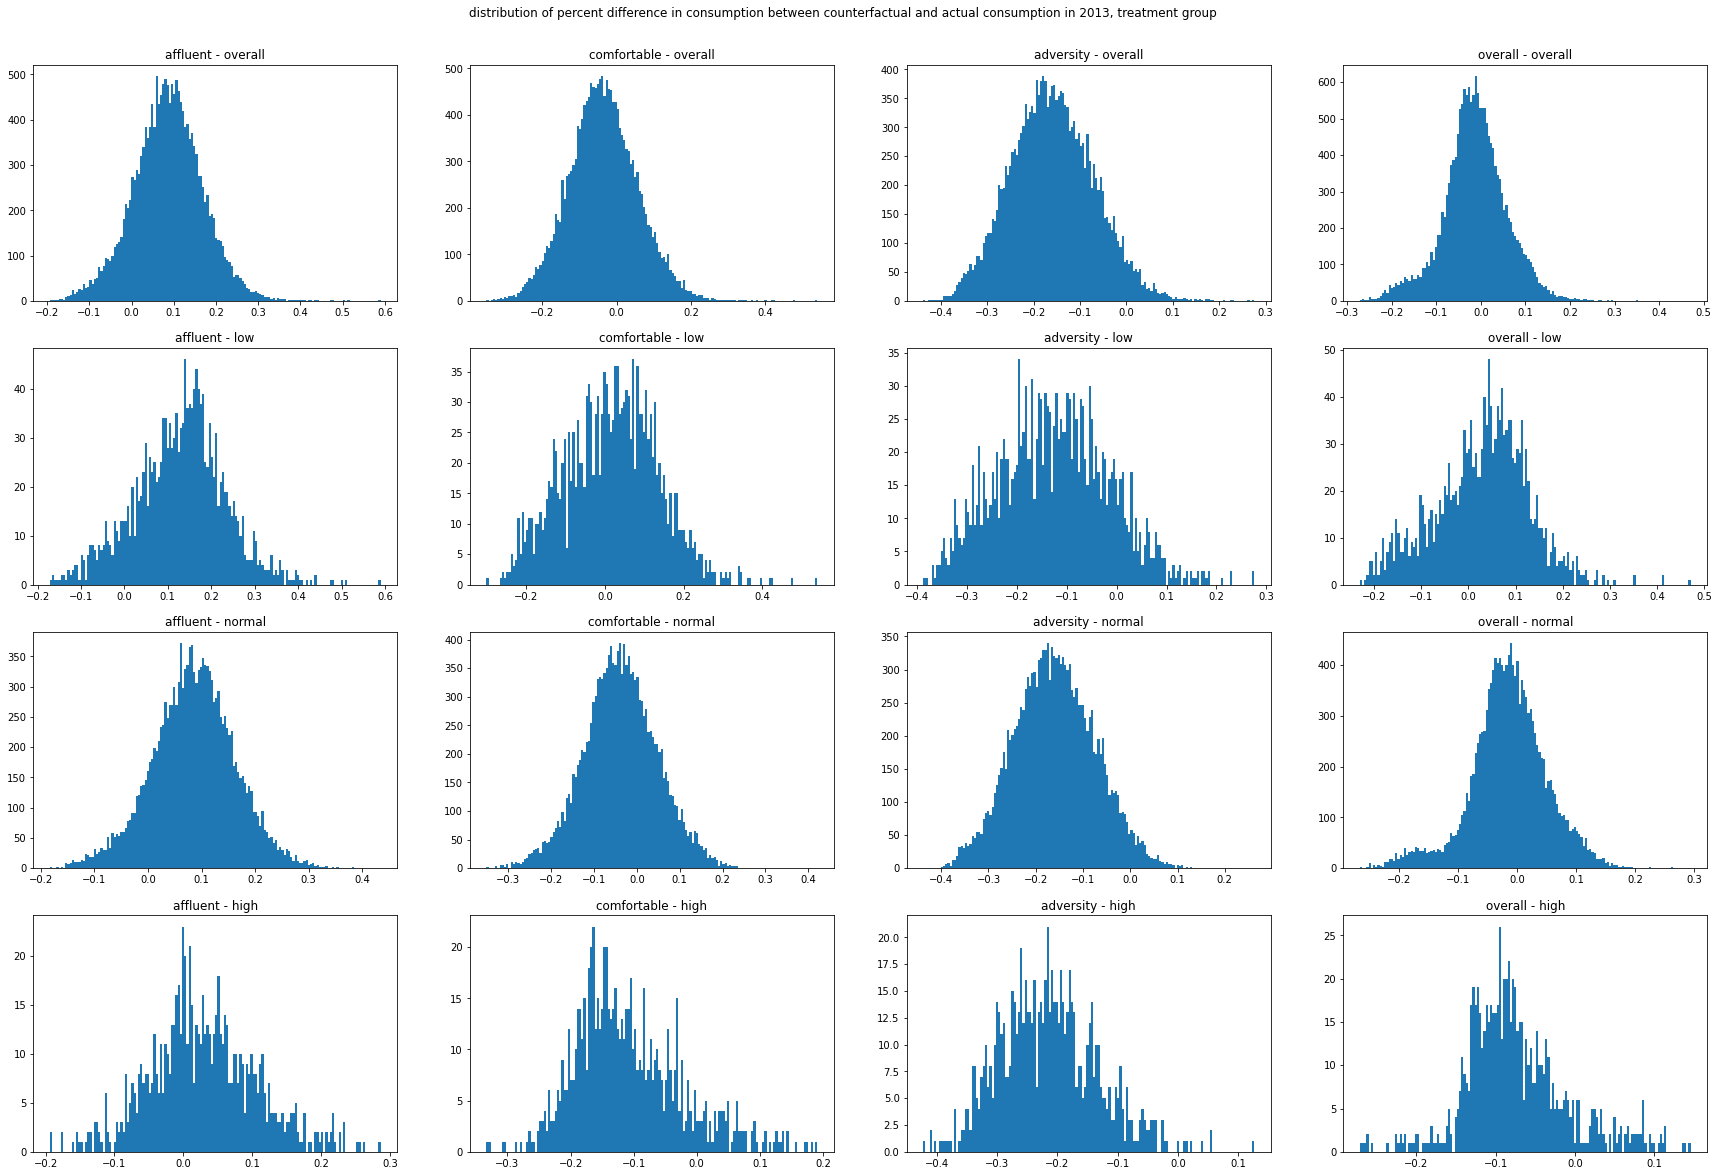

In [987]:
fig, axs = plt.subplots(4, 4, figsize=(30, 20))

axs[0, 0].hist(delta_linreg_affluent, bins=150)
axs[0, 0].set_title('affluent - overall')
axs[0, 1].hist(delta_linreg_comfortable, bins=150)
axs[0, 1].set_title('comfortable - overall')
axs[0, 2].hist(delta_linreg_adversity, bins=150)
axs[0, 2].set_title('adversity - overall')
axs[0, 3].hist(delta_linreg, bins=150)
axs[0, 3].set_title('overall - overall')


axs[1, 0].hist(delta_linreg_affluent_low, bins=150)
axs[1, 0].set_title('affluent - low')
axs[1, 1].hist(delta_linreg_comfortable_low, bins=150)
axs[1, 1].set_title('comfortable - low')
axs[1, 2].hist(delta_linreg_adversity_low, bins=150)
axs[1, 2].set_title('adversity - low')
axs[1, 3].hist(delta_linreg_low, bins=150)
axs[1, 3].set_title('overall - low')

axs[2, 0].hist(delta_linreg_affluent_normal, bins=150)
axs[2, 0].set_title('affluent - normal')
axs[2, 1].hist(delta_linreg_comfortable_normal, bins=150)
axs[2, 1].set_title('comfortable - normal')
axs[2, 2].hist(delta_linreg_adversity_normal, bins=150)
axs[2, 2].set_title('adversity - normal')
axs[2, 3].hist(delta_linreg_normal, bins=150)
axs[2, 3].set_title('overall - normal')


axs[3, 0].hist(delta_linreg_affluent_high, bins=150)
axs[3, 0].set_title('affluent - high')
axs[3, 1].hist(delta_linreg_comfortable_high, bins=150)
axs[3, 1].set_title('comfortable - high')
axs[3, 2].hist(delta_linreg_adversity_high, bins=150)
axs[3, 2].set_title('adversity - high')
axs[3, 3].hist(delta_linreg_high, bins=150)
axs[3, 3].set_title('overall - high')

fig.suptitle('distribution of percent difference in consumption between counterfactual and actual consumption in 2013, treatment group', y=0.92)
plt.savefig('linreg_distributions.png');

# axs[2, 2].xaxis.set_tick_params(which='both', labelbottom=True);

In [1074]:
np.mean(delta_linreg_price)

-0.013413517341080032

In [1077]:
np.mean(delta_linreg_price_adversity_low), np.mean(delta_linreg_price_adversity_normal), np.mean(delta_linreg_price_adversity_high)

(-0.12551046908628047, -0.16026417453746333, -0.21546083066035476)

In [1071]:
np.mean(delta_linreg_affluent), np.mean(delta_linreg_comfortable), np.mean(delta_linreg_adversity)

(0.08645918088946286, -0.03584323866512281, -0.15945388994704526)

In [1079]:
delta_linreg_affluent.mean()

0.08645918088946286